In [60]:
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, zero_one_loss
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.tree import DecisionTreeClassifier

# some PCA and GMM stuff
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

import sklearn.ensemble as ske
from sklearn.feature_selection import SelectFromModel

# Very basic wrangling (no real cleaning)

In [61]:
def load_data(filename):
    dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int16',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

    df = pd.read_csv(filename, dtype=dtypes, engine='c')
    return df

In [62]:
def reduce_mem(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and str(col_type) != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [63]:
# function to create train, dev and test sets from supplied ratios 
from sklearn.model_selection import train_test_split
def generate_train_test_dev_sets(train_ratio, test_ratio, features, labels):
    reserved_size = 1-train_ratio
    X_train, X_test_and_dev, y_train, y_test_and_dev = train_test_split(features, labels, stratify=labels, test_size=reserved_size, random_state=0)
    reserved_size = 1 - (test_ratio / reserved_size)
    X_test, X_dev, y_test, y_dev = train_test_split(X_test_and_dev, y_test_and_dev, stratify=y_test_and_dev, test_size=reserved_size, random_state=0)
    return X_train, X_test, X_dev, y_train, y_test, y_dev


In [64]:
def save_file(df, name):
    df.to_csv("data.nosync/"+name+".csv", index=False)

In [9]:
filename = "data.nosync/train.csv"
#df = pd.read_csv(filename, engine='c') # first time run - we don't know the dtypes
df = load_data(filename)

/Users/kevin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
df = reduce_mem(df)
import gc
gc.collect()

Memory usage of dataframe is 5649.44 MB
Memory usage after optimization is: 1681.76 MB
Decreased by 70.2%


11

In [11]:
#code to spit out a nicely formated set of definitions for dtypes (for use in loading the sets again as above)
for dtype in df.dtypes.items():
    print("'{:} '{:}',".format((dtype[0] + "':").ljust(54), dtype[1]))

'MachineIdentifier':                                    'category',
'ProductName':                                          'category',
'EngineVersion':                                        'category',
'AppVersion':                                           'category',
'AvSigVersion':                                         'category',
'IsBeta':                                               'int8',
'RtpStateBitfield':                                     'float16',
'IsSxsPassiveMode':                                     'int8',
'DefaultBrowsersIdentifier':                            'float16',
'AVProductStatesIdentifier':                            'float32',
'AVProductsInstalled':                                  'float16',
'AVProductsEnabled':                                    'float16',
'HasTpm':                                               'int8',
'CountryIdentifier':                                    'int16',
'CityIdentifier':                                       'float32',
'

In [12]:
train, test, dev, train_labels, test_labels, dev_labels = \
    generate_train_test_dev_sets(.7, .15, df, df['HasDetections'])

print("shape of train set:",train.shape)
print("shape of dev set:",dev.shape) 
print("shape of test set:",test.shape)

# save cleaned files
#
print("saving train_clean ...")
save_file(train, "train_clean")
print("saving dev_clean ...")
save_file(dev, "dev_clean")
print("saving test_clean ...")
save_file(test, "test_clean")
print("done saving files")

shape of train set: (6245038, 83)
shape of dev set: (1338223, 83)
shape of test set: (1338222, 83)
saving train_clean ...
saving dev_clean ...
saving test_clean ...
done saving files


## create minis from the same files

In [14]:
from sklearn.model_selection import train_test_split
def generate_mini(n, features, labels):
    sample_size = n / features.shape[0]
    reserved_size = 1-sample_size
    X_mini, X_rest, y_mini, y_rest = train_test_split(features, labels, stratify=labels, test_size=reserved_size, random_state=0)
    return X_mini, X_rest, y_mini, y_rest

In [17]:
mini_ratio = .05

mini_train, remaining, mini_train_labels, remaining_labels = \
    generate_mini(train.shape[0]*mini_ratio, train, train['HasDetections'])

mini_dev, remaining, mini_dev_labels, remaining_labels = \
    generate_mini(dev.shape[0]*mini_ratio, dev, dev['HasDetections'])

mini_test, remaining, mini_test_labels, remaining_labels = \
    generate_mini(test.shape[0]*mini_ratio, test, test['HasDetections'])


In [19]:
print("shape of mini train set:",mini_train.shape)
print("shape of mini dev set:",mini_dev.shape)
print("shape of mini test set:",mini_test.shape)

# save mini files
#
print("saving mini_train_clean ...")
save_file(mini_train, "mini_train_clean")
print("saving mini_dev_clean ...")
save_file(mini_dev, "mini_dev_clean")
print("saving mini_test_clean ...")
save_file(mini_test, "mini_test_clean")
print("done saving files")

shape of mini train set: (312251, 83)
shape of mini dev set: (66911, 83)
shape of mini test set: (66911, 83)
saving mini_train_clean ...
saving mini_dev_clean ...
saving mini_test_clean ...
done saving files


# Work in progress steps for an analysis / encoding / feature engineering notebook. Move/replace/reuse when we are ready.

In [65]:
train_file = 'data.nosync/mini_train_clean.csv'
dev_file = 'data.nosync/mini_dev_clean.csv'
test_file = 'data.nosync/mini_test_clean.csv'

In [66]:
train_data = load_data(train_file)
train_data = reduce_mem(train_data)
train_labels = train_data['HasDetections']
import gc
gc.collect()
train_data = train_data.drop(columns=['HasDetections', 'MachineIdentifier'])

Memory usage of dataframe is 57.90 MB
Memory usage after optimization is: 57.30 MB
Decreased by 1.0%


In [67]:
dev_data = load_data(dev_file)
dev_data = reduce_mem(dev_data)
dev_labels = dev_data['HasDetections']
import gc
gc.collect()
dev_data = dev_data.drop(columns=['HasDetections', 'MachineIdentifier'])

Memory usage of dataframe is 12.93 MB
Memory usage after optimization is: 12.80 MB
Decreased by 1.0%


In [68]:
test_data = load_data(test_file)
test_data = reduce_mem(test_data)
test_labels = test_data['HasDetections']
import gc
gc.collect()
test_data = test_data.drop(columns=['HasDetections', 'MachineIdentifier'])

Memory usage of dataframe is 12.93 MB
Memory usage after optimization is: 12.67 MB
Decreased by 2.0%


In [69]:
all_cols = []
for item in train_data.dtypes.items():
    #print("'{:}',".format(item[0]))
    all_cols.append(item[0])

In [70]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = [c for c,v in train_data.dtypes.items() if v in numerics and c in train_data.columns]

In [71]:
nominal_cols = [c for c in train_data.columns if (c not in numeric_cols)]

In [72]:
binary_cols = [c for c in train_data.columns if (train_data[c].nunique() == 2 and c not in nominal_cols)]

In [73]:
unary_cols = [c for c in train_data.columns if (train_data[c].nunique() == 1 and c not in nominal_cols)]
unary_cols

['Census_IsWIMBootEnabled']

In [74]:
[c for c in dev_data.columns if (dev_data[c].nunique() == 1 and c not in nominal_cols)]

['IsBeta', 'Census_IsFlightingInternal', 'Census_IsWIMBootEnabled']

In [75]:
[c for c in test_data.columns if (test_data[c].nunique() == 1 and c not in nominal_cols)]

['AutoSampleOptIn',
 'Census_IsFlightingInternal',
 'Census_IsFlightsDisabled',
 'Census_IsWIMBootEnabled']

In [76]:
continuous_cols = [c for c in numeric_cols if (c not in np.concatenate((binary_cols, unary_cols)))]

In [ ]:
#for c in unary_cols:
#    train_data = train_data.drop(columns=c)
#    test_data = test_data.drop(columns=c)
#    dev_data = dev_data.drop(columns=c)

In [78]:
for item in train_data[all_cols].dtypes.items():
    print(item)

('ProductName', CategoricalDtype(categories=['mse', 'win8defender', 'mseprerelease', 'scep'], ordered=False))
('EngineVersion', CategoricalDtype(categories=['1.1.12805.0', '1.1.12902.0', '1.1.13000.0', '1.1.13103.0',
                  '1.1.13202.0', '1.1.13303.0', '1.1.13407.0', '1.1.13504.0',
                  '1.1.13601.0', '1.1.13701.0', '1.1.13704.0', '1.1.13804.0',
                  '1.1.13903.0', '1.1.14003.0', '1.1.14104.0', '1.1.14202.0',
                  '1.1.14303.0', '1.1.14305.0', '1.1.14306.0', '1.1.14405.2',
                  '1.1.14500.5', '1.1.14600.4', '1.1.14700.3', '1.1.14700.4',
                  '1.1.14700.5', '1.1.14800.1', '1.1.14800.3', '1.1.14901.3',
                  '1.1.14901.4', '1.1.15000.1', '1.1.15000.2', '1.1.15100.1',
                  '1.1.15200.1', '1.1.15300.5', '1.1.15300.6', '1.1.11502.0',
                  '1.1.12101.0', '1.1.13802.0', '1.1.11701.0', '1.1.14002.0',
                  '1.1.14102.0', '1.1.14201.0', '1.1.14500.2', '1.1.13102.0',
   

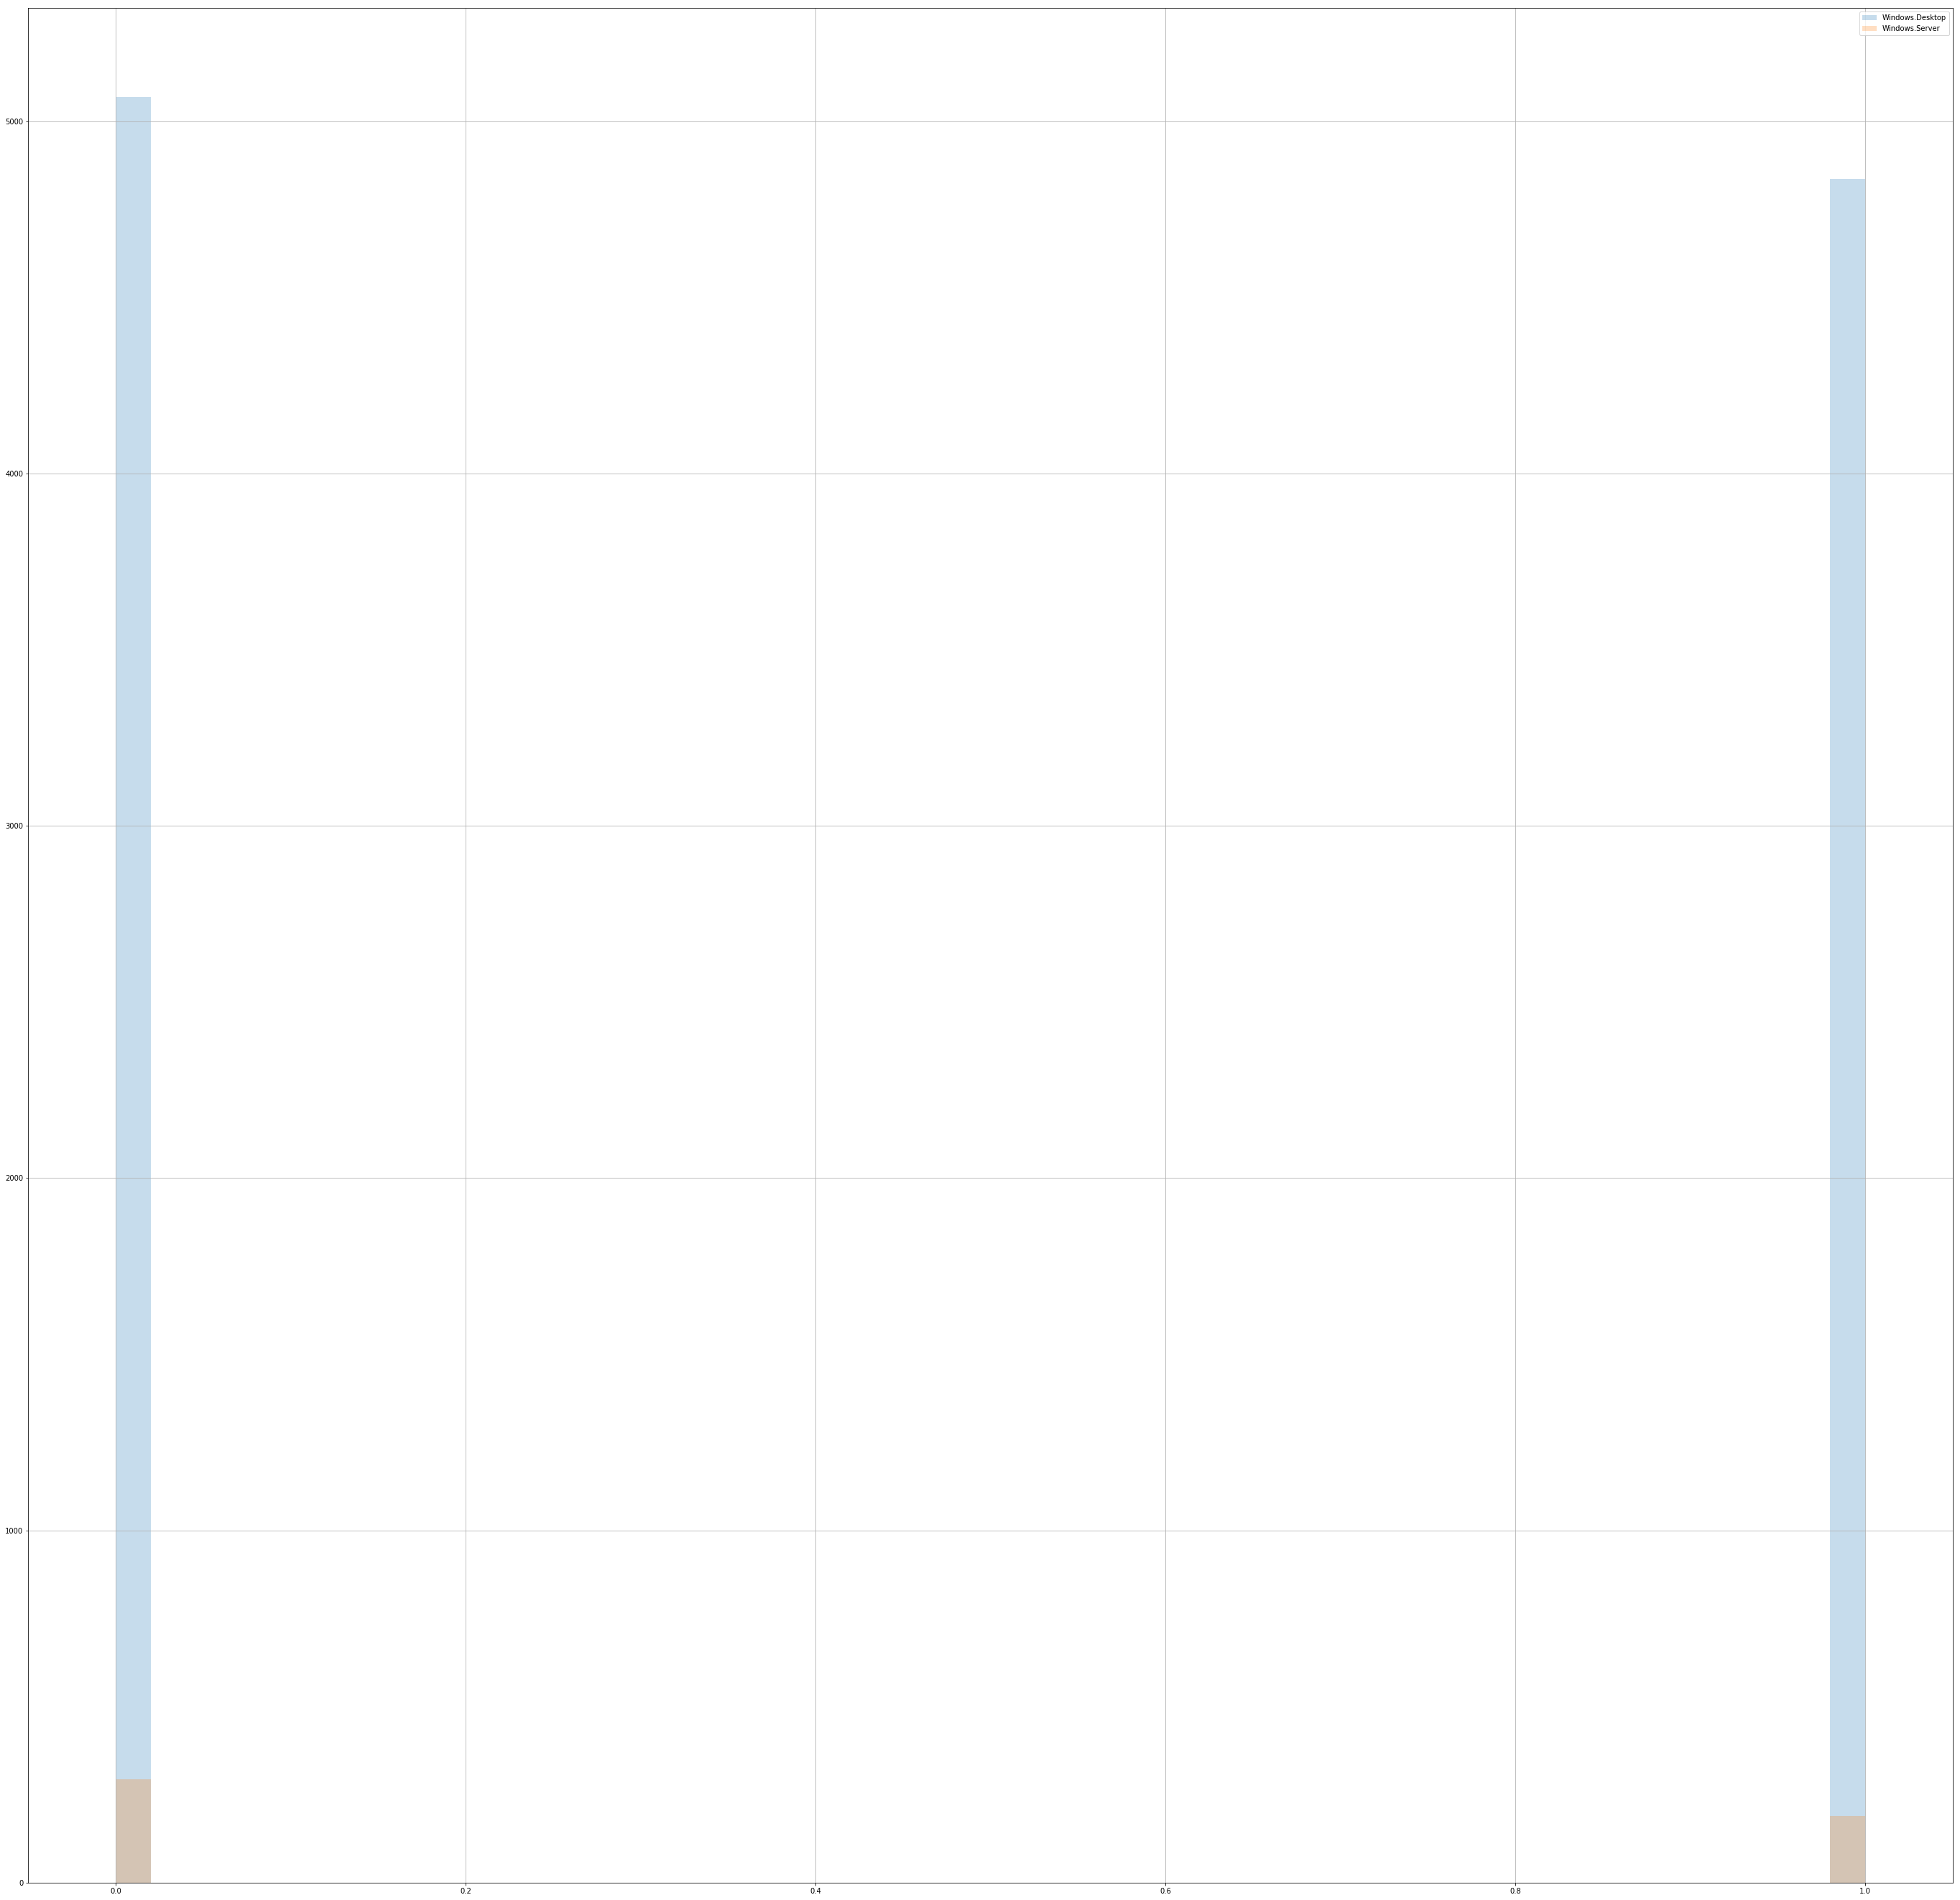

In [79]:
train_data['HasDetections'] = train_labels

filter=train_data['Platform']!='windows10'

groups = train_data[filter].groupby('Census_DeviceFamily').HasDetections

fig, ax = plt.subplots()

for k, v in groups:
    v.hist(label=k, alpha=.25, ax=ax, figsize=(48,48), bins=50)

ax.legend()
train_data = train_data.drop(columns='HasDetections')

In [80]:
# Additional encoding TBD
print("Columns to review NaN values:")
train_data.isna().any()[lambda x: x]

Columns to review NaN values:


RtpStateBitfield                                     True
DefaultBrowsersIdentifier                            True
AVProductStatesIdentifier                            True
AVProductsInstalled                                  True
AVProductsEnabled                                    True
CityIdentifier                                       True
OrganizationIdentifier                               True
GeoNameIdentifier                                    True
IsProtected                                          True
PuaMode                                              True
SMode                                                True
IeVerIdentifier                                      True
SmartScreen                                          True
Firewall                                             True
UacLuaenable                                         True
Census_OEMNameIdentifier                             True
Census_OEMModelIdentifier                            True
Census_Process

In [81]:
# Let's get a feeling for range of values in the nominal categories

In [82]:
train_data[nominal_cols].describe().transpose()

,count,unique,top,freq
ProductName,312251,4,win8defender,309056
EngineVersion,312251,51,1.1.15200.1,134543
AppVersion,312251,85,4.18.1807.18075,179773
AvSigVersion,312251,5784,1.273.1420.0,3686
Platform,312251,4,windows10,301861
Processor,312251,3,x64,283662
OsVer,312251,10,10.0.0.0,302333
OsPlatformSubRelease,312251,9,rs4,136776
OsBuildLab,312251,426,17134.1.amd64fre.rs4_release.180410-1804,127761
SkuEdition,312251,8,Home,193289


In [83]:
# Encode nominal variables as labeled strings
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
for i, col in enumerate(nominal_cols):
    train_data[col] = encoder.fit_transform(train_data[col].astype(str))
    dev_data[col] = encoder.fit_transform(dev_data[col].astype(str))
    test_data[col] = encoder.fit_transform(test_data[col].astype(str))

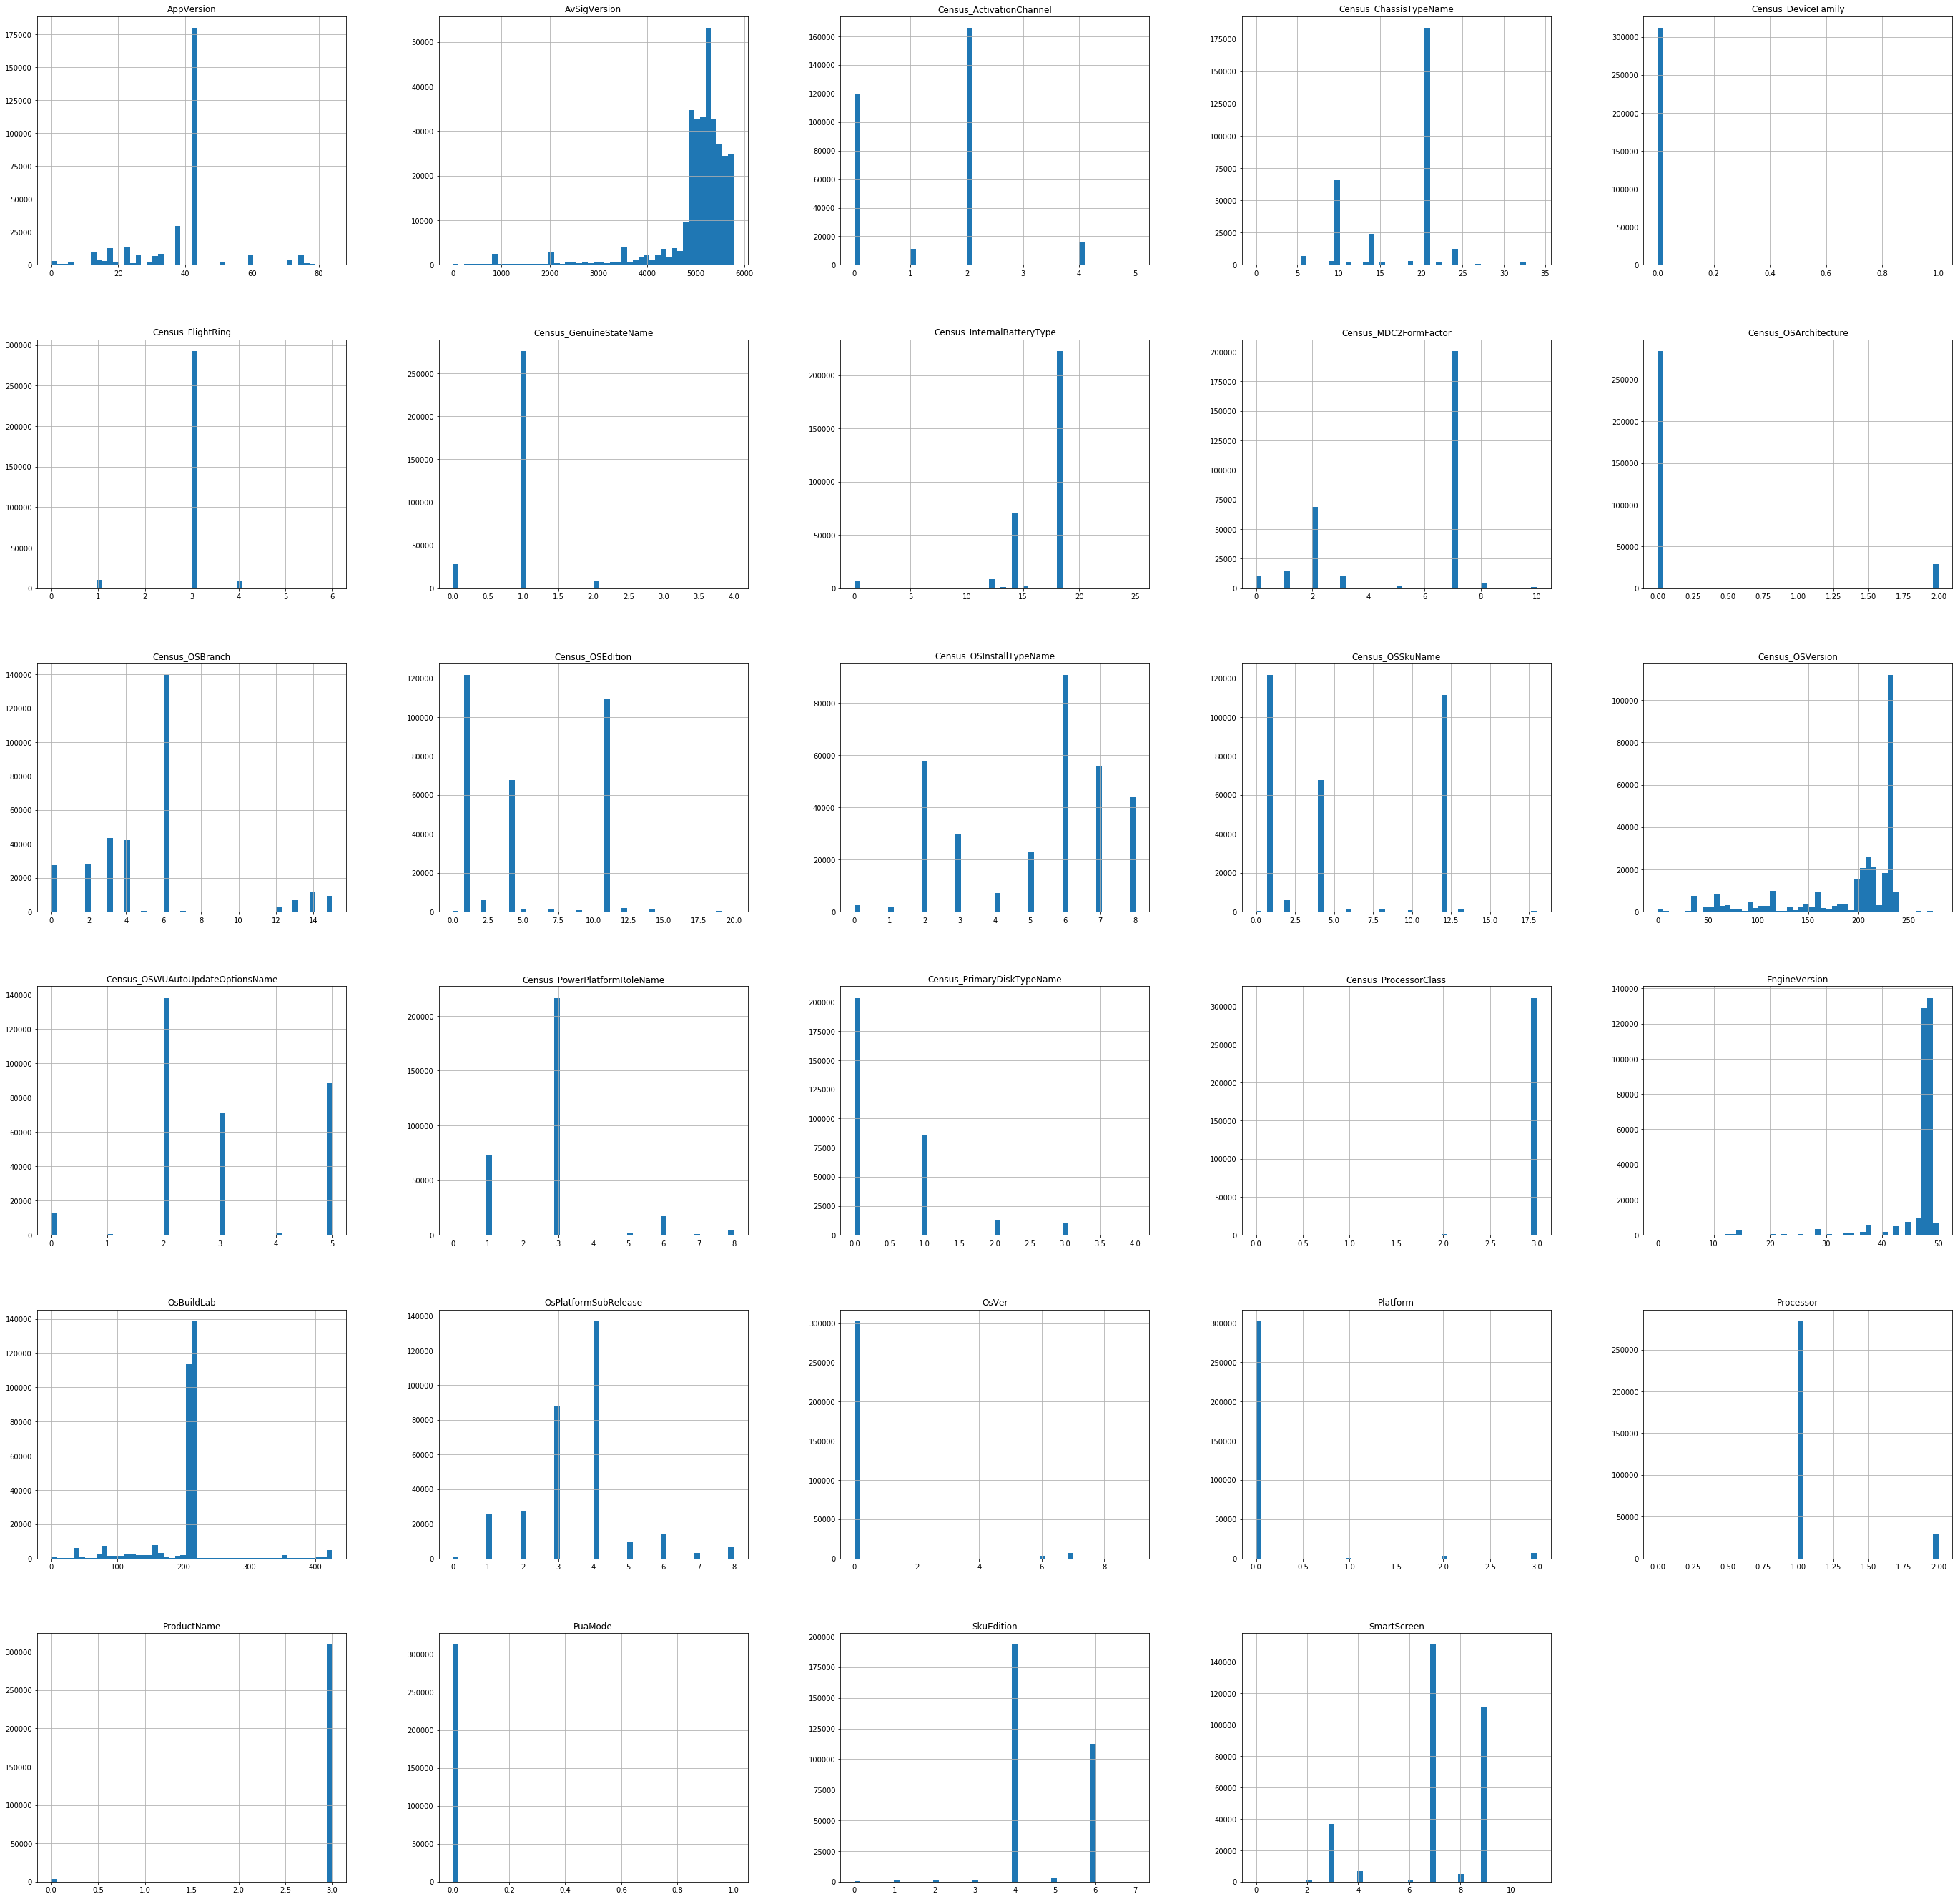

In [84]:
train_data[nominal_cols].hist(figsize=(48,48), bins=50)
plt.show()

In [85]:
for i, col in enumerate(nominal_cols):
    print('The number of values for {:} = {:}'.format(col, (len(list(train_data[col].unique())))))

The number of values for ProductName = 4
The number of values for EngineVersion = 51
The number of values for AppVersion = 85
The number of values for AvSigVersion = 5784
The number of values for Platform = 4
The number of values for Processor = 3
The number of values for OsVer = 10
The number of values for OsPlatformSubRelease = 9
The number of values for OsBuildLab = 426
The number of values for SkuEdition = 8
The number of values for PuaMode = 2
The number of values for SmartScreen = 12
The number of values for Census_MDC2FormFactor = 11
The number of values for Census_DeviceFamily = 2
The number of values for Census_ProcessorClass = 4
The number of values for Census_PrimaryDiskTypeName = 5
The number of values for Census_ChassisTypeName = 35
The number of values for Census_PowerPlatformRoleName = 9
The number of values for Census_InternalBatteryType = 26
The number of values for Census_OSVersion = 281
The number of values for Census_OSArchitecture = 3
The number of values for Censu

In [86]:
correlated_cols = []
for i, col in enumerate(nominal_cols):
    corr = train_labels.corr(train_data[col])
    if(corr > 0.05  or corr < -0.05):
        star='(*)' # flag the highly correlated nominal variables
        correlated_cols.append(col)
    else:
        star=''
    print('The correlation of {:} with the outcome variable is {:7.6f}{:}'.format(col, corr, star))

The correlation of ProductName with the outcome variable is 0.004787
The correlation of EngineVersion with the outcome variable is 0.049902
The correlation of AppVersion with the outcome variable is 0.021835
The correlation of AvSigVersion with the outcome variable is 0.053625(*)
The correlation of Platform with the outcome variable is -0.004381
The correlation of Processor with the outcome variable is -0.074339(*)
The correlation of OsVer with the outcome variable is -0.003990
The correlation of OsPlatformSubRelease with the outcome variable is 0.015295
The correlation of OsBuildLab with the outcome variable is 0.014948
The correlation of SkuEdition with the outcome variable is 0.016260
The correlation of PuaMode with the outcome variable is 0.007944
The correlation of SmartScreen with the outcome variable is -0.169002(*)
The correlation of Census_MDC2FormFactor with the outcome variable is -0.008530
The correlation of Census_DeviceFamily with the outcome variable is -0.008450
The cor

In [87]:
correlated_cols

['AvSigVersion', 'Processor', 'SmartScreen', 'Census_OSArchitecture']

In [88]:
train_data[continuous_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
RtpStateBitfield,311109.0,NaN,0.000000e+00,0.000000,7.000000,7.0,7.000000e+00,8.000000e+00
DefaultBrowsersIdentifier,15321.0,inf,inf,1.000000,788.000000,1632.0,2.290000e+03,3.204000e+03
AVProductStatesIdentifier,311012.0,4.773353e+04,1.408851e+04,7.000000,49480.000000,53447.0,5.344700e+04,7.049200e+04
AVProductsInstalled,311012.0,NaN,0.000000e+00,1.000000,1.000000,1.0,2.000000e+00,6.000000e+00
AVProductsEnabled,311012.0,NaN,0.000000e+00,0.000000,1.000000,1.0,1.000000e+00,5.000000e+00
CountryIdentifier,312251.0,1.080395e+02,6.310664e+01,1.000000,51.000000,97.0,1.620000e+02,2.220000e+02
CityIdentifier,300952.0,8.109947e+04,4.894281e+04,9.000000,36649.000000,82373.0,1.229320e+05,1.679540e+05
OrganizationIdentifier,215968.0,NaN,0.000000e+00,1.000000,18.000000,27.0,2.700000e+01,5.200000e+01
GeoNameIdentifier,312240.0,NaN,NaN,1.000000,89.000000,181.0,2.670000e+02,2.960000e+02
LocaleEnglishNameIdentifier,312251.0,1.226801e+02,6.924121e+01,1.000000,74.000000,88.0,1.820000e+02,2.830000e+02


In [89]:
# Andrew's temporary draft for StandardScaler.  Pasting in Kevin's variation, as well:

#inverse_cols = [i for i in train_data.columns if i not in numeric_cols]
#features = train_data[numeric_cols]
#ct = ColumnTransformer([('transform', StandardScaler(), numeric_cols)], remainder='passthrough')
#ct.fit_transform(features)
#train_data_scaled = pd.DataFrame(features, index=train_data.index, columns=numeric_cols)
#inverse_data = pd.DataFrame(train_data[inverse_cols], index=train_data.index, columns=inverse_cols)
#frames = [train_data_scaled, inverse_data]
#train_data2 = pd.concat(frames, sort=False)
#train_data2.describe()

# Kevin's version:
from sklearn.preprocessing import StandardScaler
features = train_data[continuous_cols]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
train_data[continuous_cols] = features

#from sklearn.preprocessing import StandardScaler
#train_data[numeric_cols] = data[[numeric_cols].apply(
#                           lambda x: StandardScaler().fit_transform(x))


features = dev_data[continuous_cols]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
dev_data[continuous_cols] = features

features = test_data[continuous_cols]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
test_data[continuous_cols] = features


#for i, col in enumerate(numeric_cols):
#    standard_scaler = StandardScaler().fit(train_data[col].values)
#    train_data[col] = standard_scaler.transform(train_data[col])
#    test_data[col] = standard_scaler.transform(test_data[col])



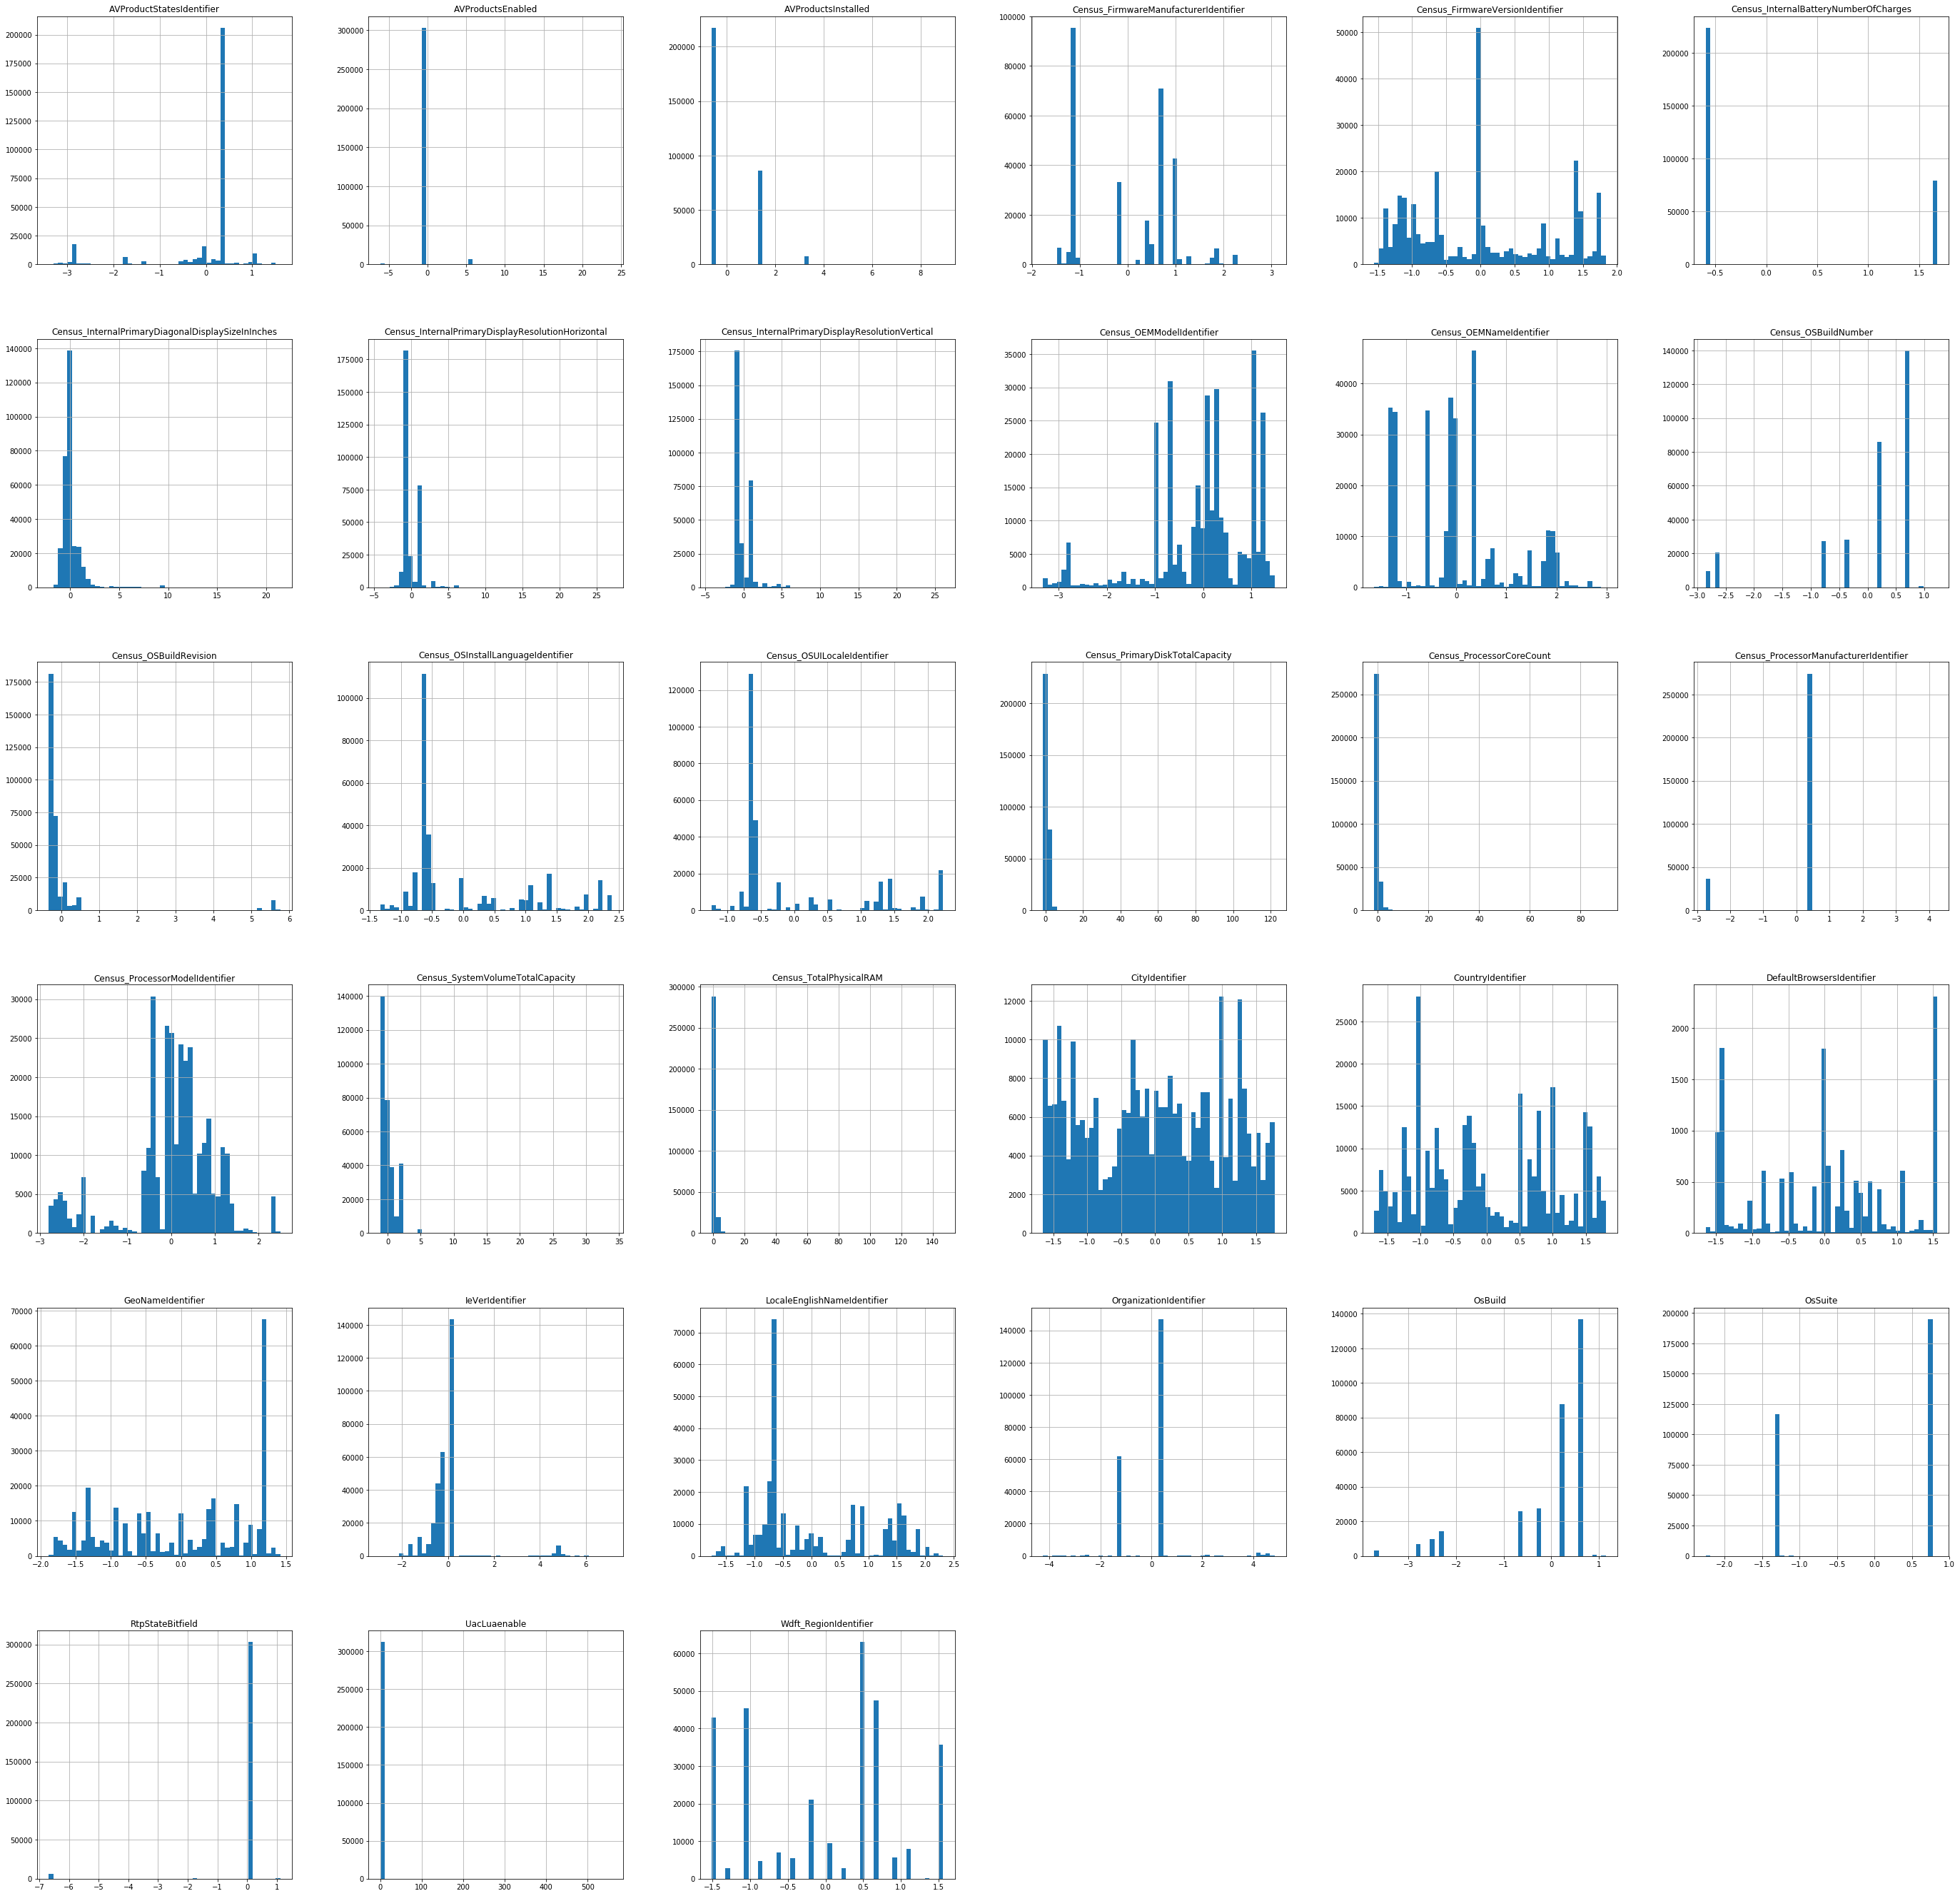

In [90]:
train_data[continuous_cols].hist(figsize=(48,48), bins=50)
plt.show()

In [91]:
train_data[binary_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
IsBeta,312251.0,0.000019,0.004383,0.0,0.0,0.0,0.0,1.0
IsSxsPassiveMode,312251.0,0.017476,0.131038,0.0,0.0,0.0,0.0,1.0
HasTpm,312251.0,0.988343,0.107338,0.0,1.0,1.0,1.0,1.0
IsProtected,311022.0,NaN,0.000000,0.0,1.0,1.0,1.0,1.0
AutoSampleOptIn,312251.0,0.000038,0.006199,0.0,0.0,0.0,0.0,1.0
SMode,293574.0,0.000473,0.021744,0.0,0.0,0.0,0.0,1.0
Firewall,309168.0,NaN,0.000000,0.0,1.0,1.0,1.0,1.0
Census_HasOpticalDiskDrive,312251.0,0.076506,0.265806,0.0,0.0,0.0,0.0,1.0
Census_IsPortableOperatingSystem,312251.0,0.000512,0.022631,0.0,0.0,0.0,0.0,1.0
Census_IsFlightingInternal,52784.0,0.000019,0.004353,0.0,0.0,0.0,0.0,1.0


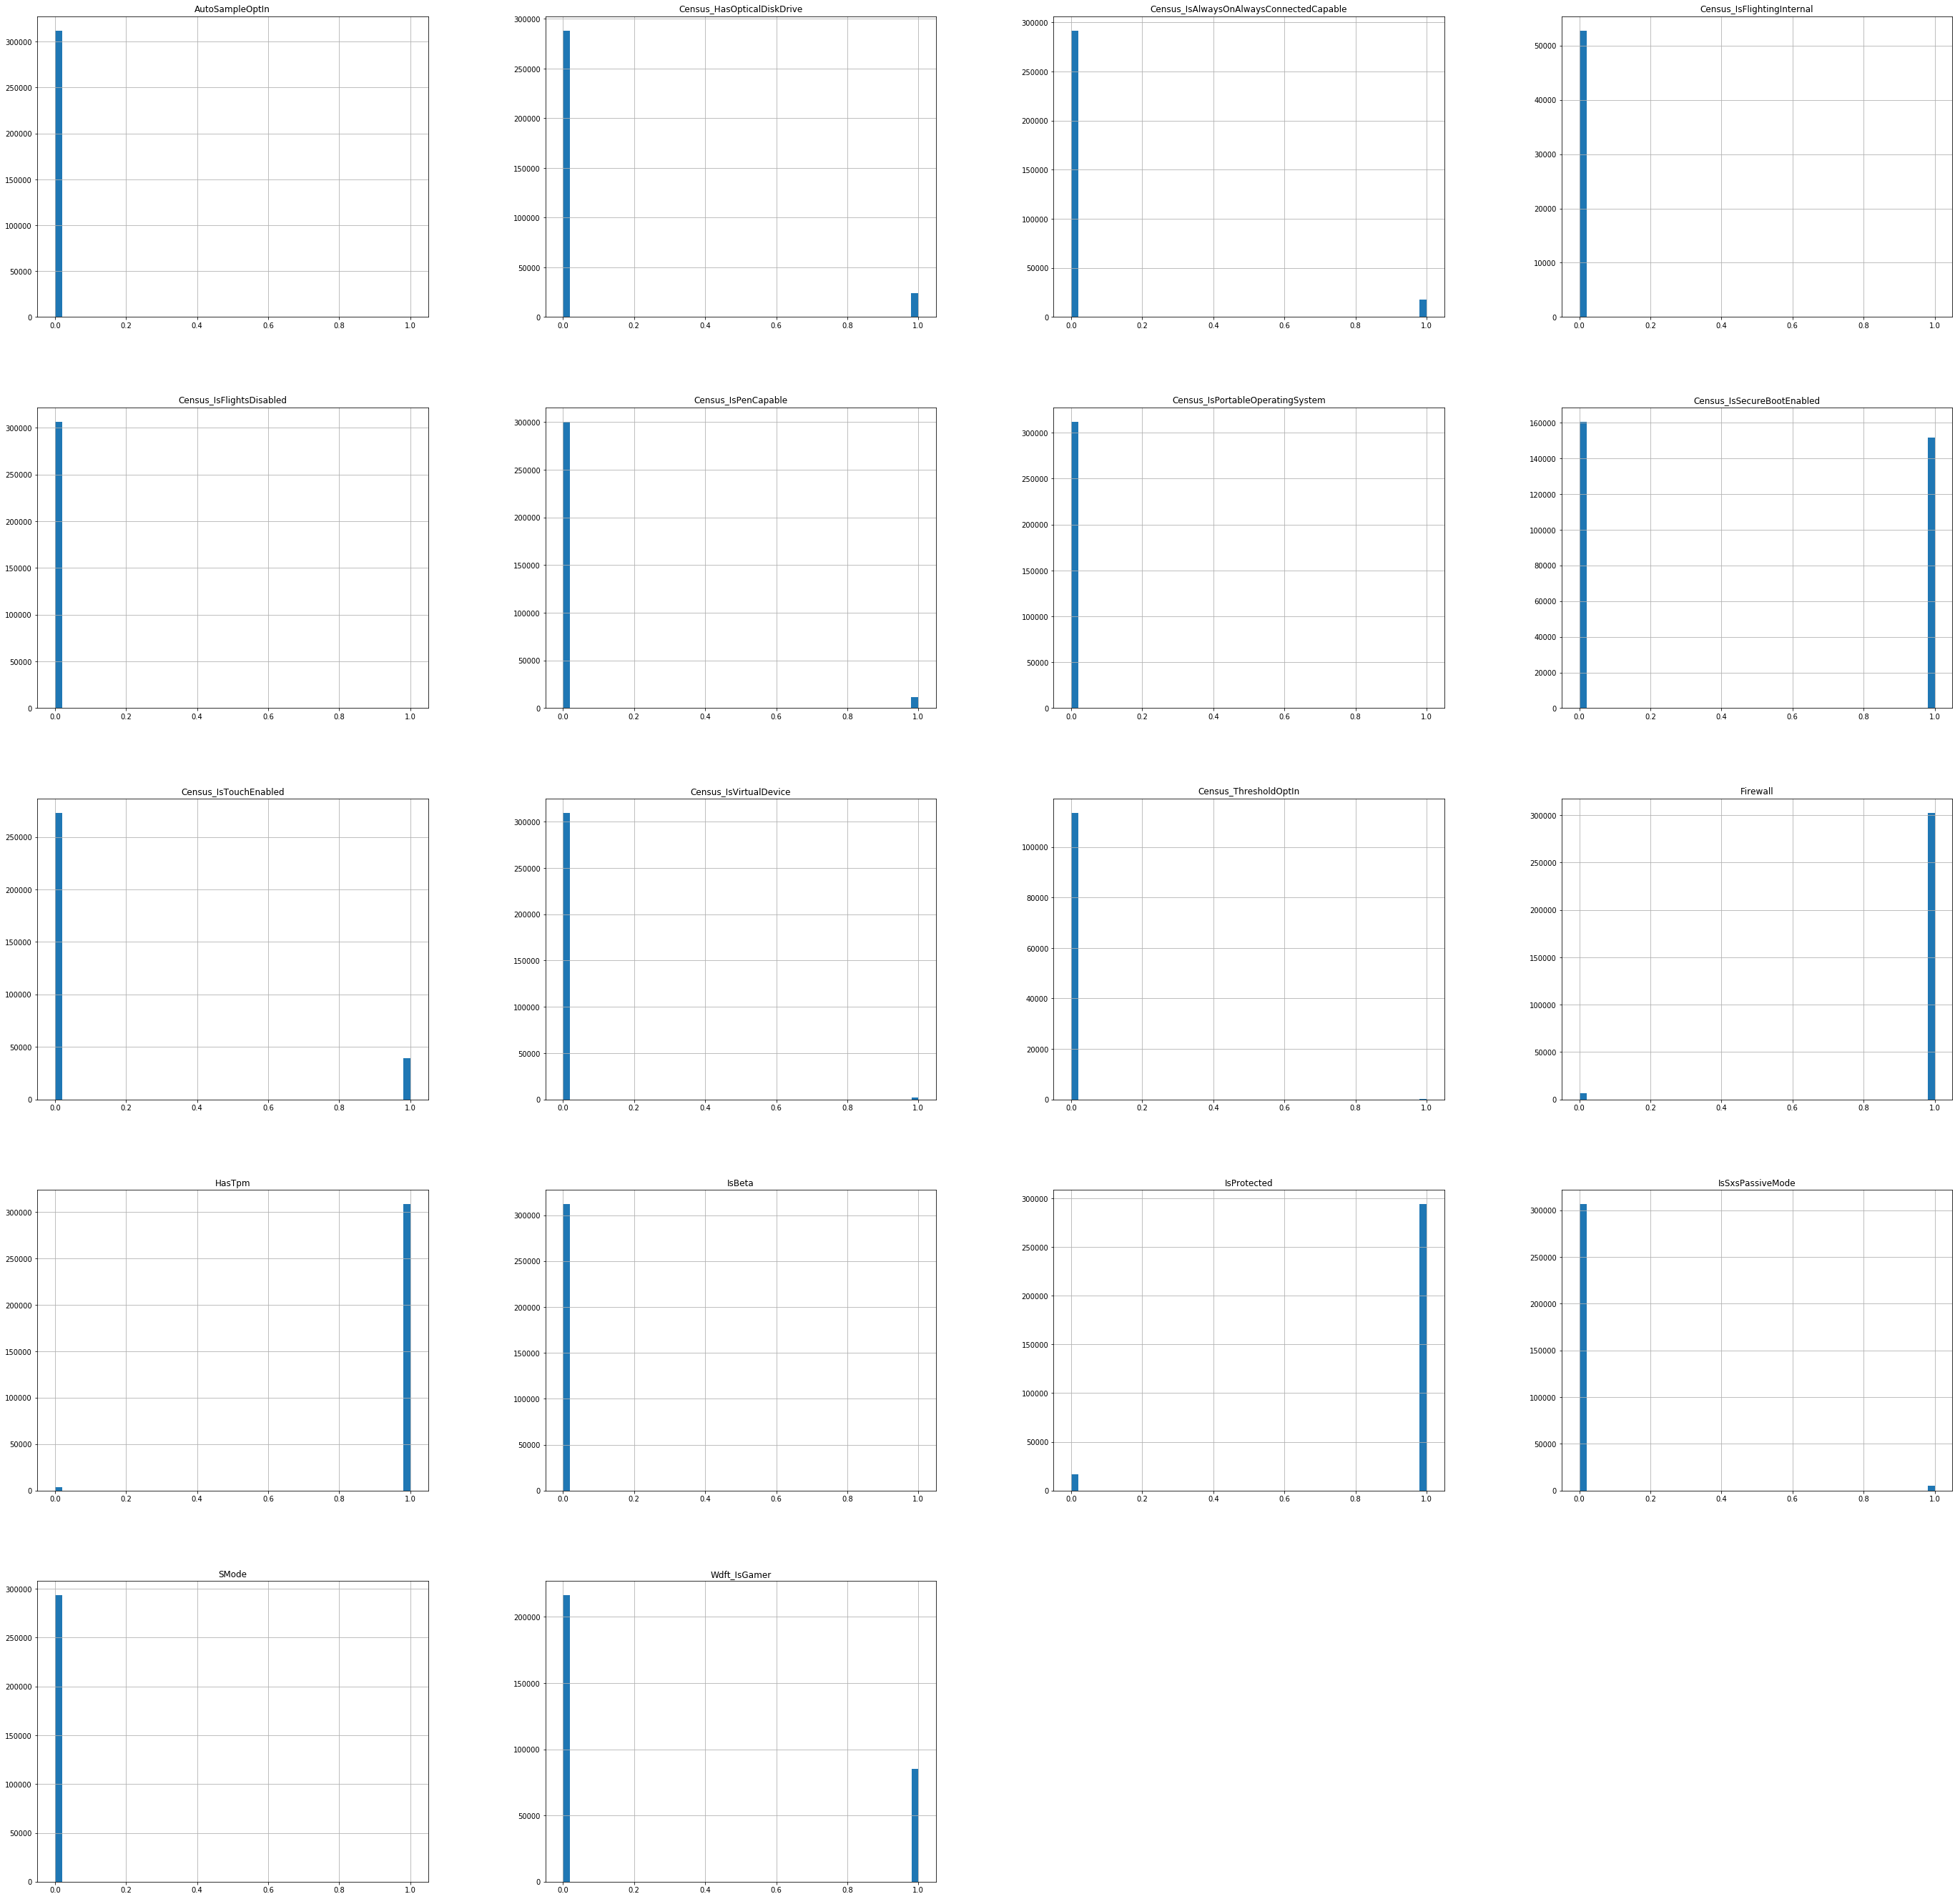

In [92]:
train_data[binary_cols].hist(figsize=(48,48), bins=50)
plt.show()

In [93]:
for i, col in enumerate(numeric_cols):
    corr = train_labels.corr(train_data[col])
    if(corr > 0.05  or corr < -0.05):
        star='(*)' # flag the highly correlated numeric variables
        correlated_cols.append(col)
    else:
        star=''
    print('The correlation of {:} with the outcome variable is {:7.6f}{:}'.format(col, corr, star))

The correlation of IsBeta with the outcome variable is 0.000002
The correlation of RtpStateBitfield with the outcome variable is 0.041404
The correlation of IsSxsPassiveMode with the outcome variable is -0.036238
The correlation of DefaultBrowsersIdentifier with the outcome variable is -0.012378
The correlation of AVProductStatesIdentifier with the outcome variable is 0.119017(*)
The correlation of AVProductsInstalled with the outcome variable is -0.148211(*)
The correlation of AVProductsEnabled with the outcome variable is -0.042516
The correlation of HasTpm with the outcome variable is 0.007116
The correlation of CountryIdentifier with the outcome variable is 0.005088
The correlation of CityIdentifier with the outcome variable is -0.003378
The correlation of OrganizationIdentifier with the outcome variable is 0.004419
The correlation of GeoNameIdentifier with the outcome variable is 0.004073
The correlation of LocaleEnglishNameIdentifier with the outcome variable is 0.013677
The corr

In [102]:
# Impute missing values for correlated columns

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

imputer.fit(train_data[correlated_cols])
train_data_corr = imputer.transform(train_data[correlated_cols])
dev_data_corr = imputer.transform(dev_data[correlated_cols])
test_data_corr = imputer.transform(test_data[correlated_cols])


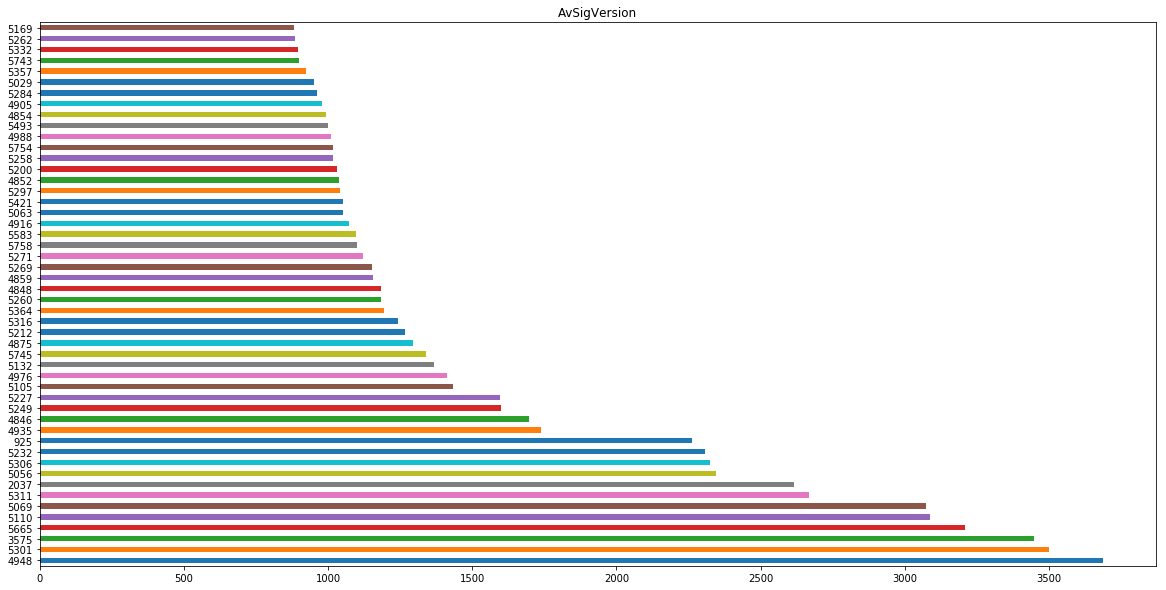

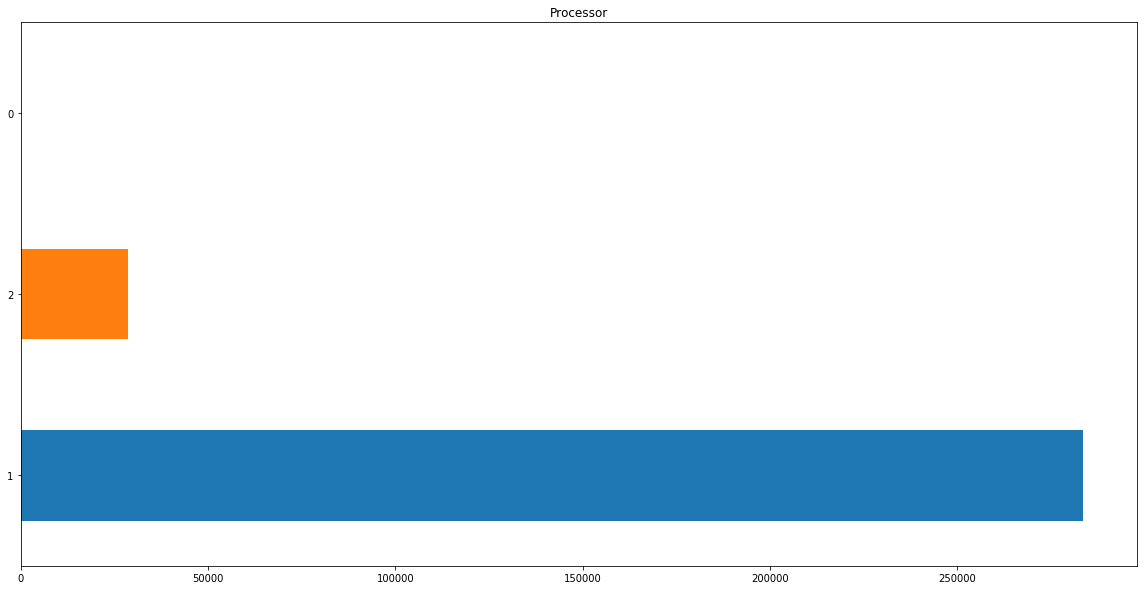

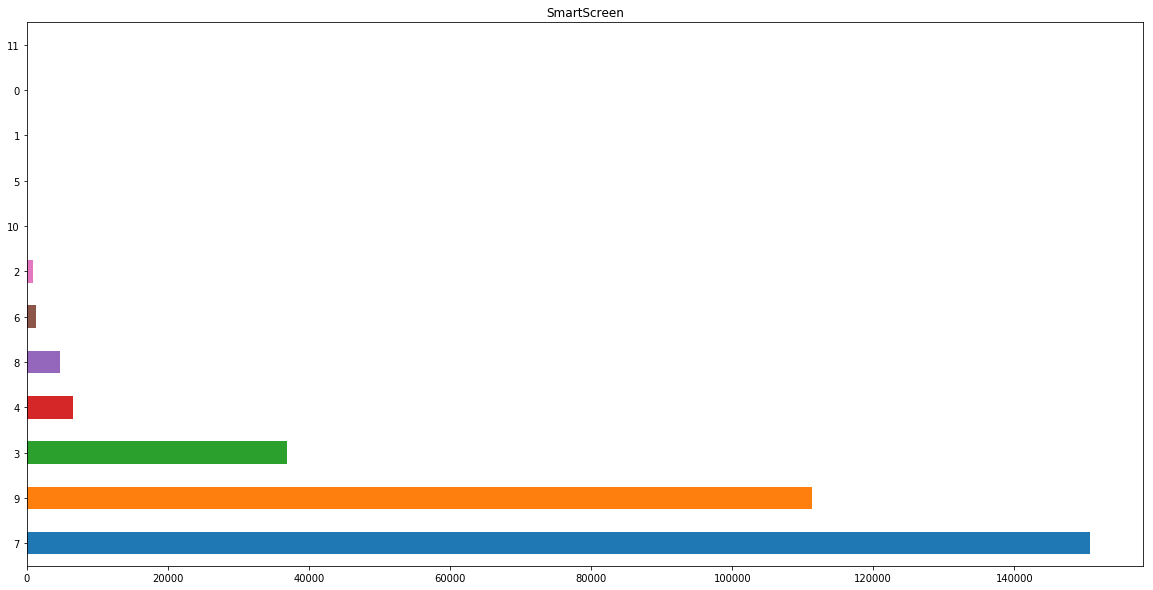

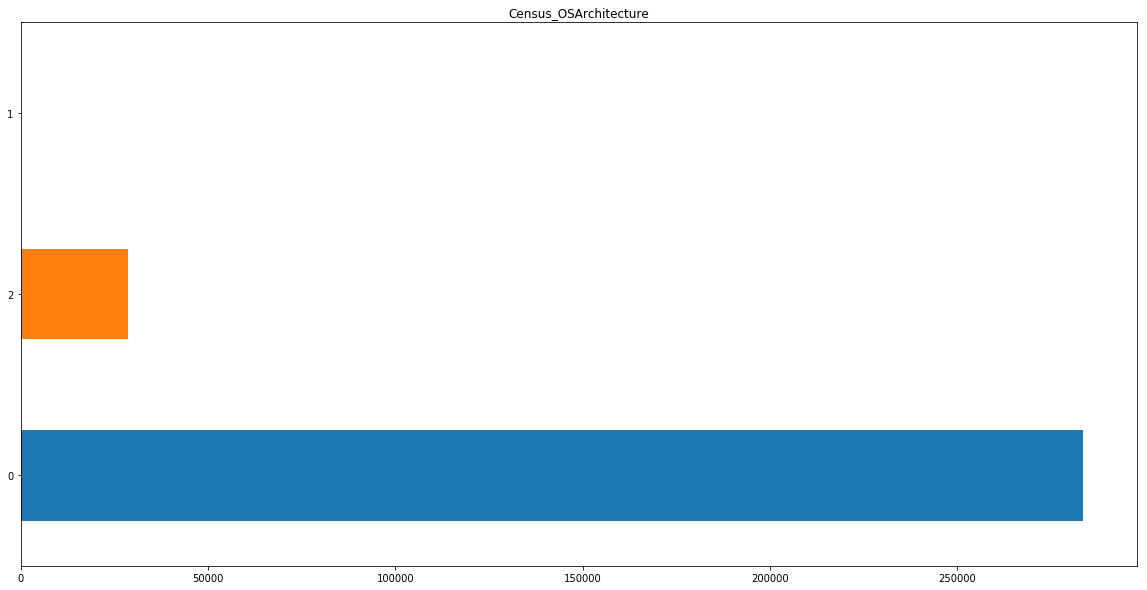

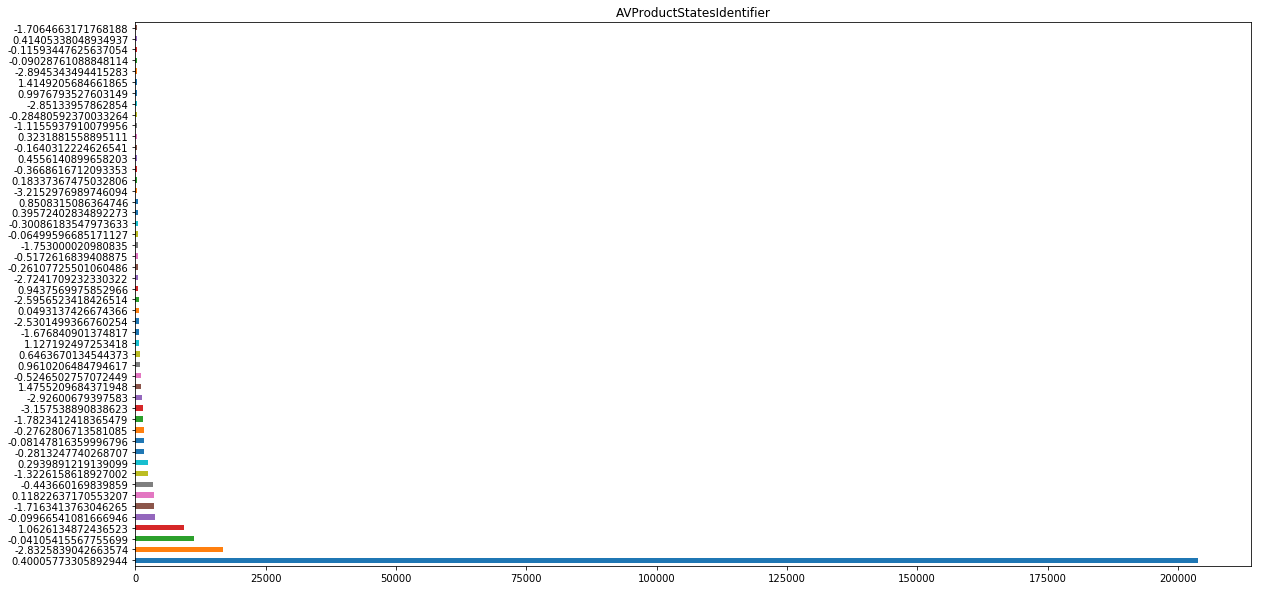

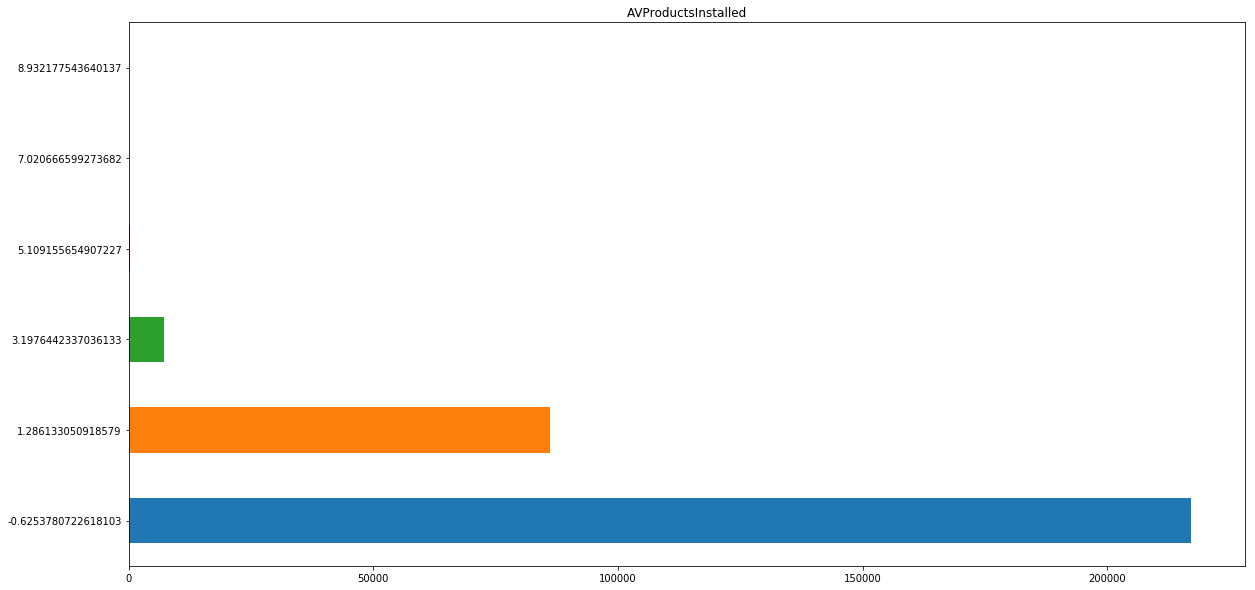

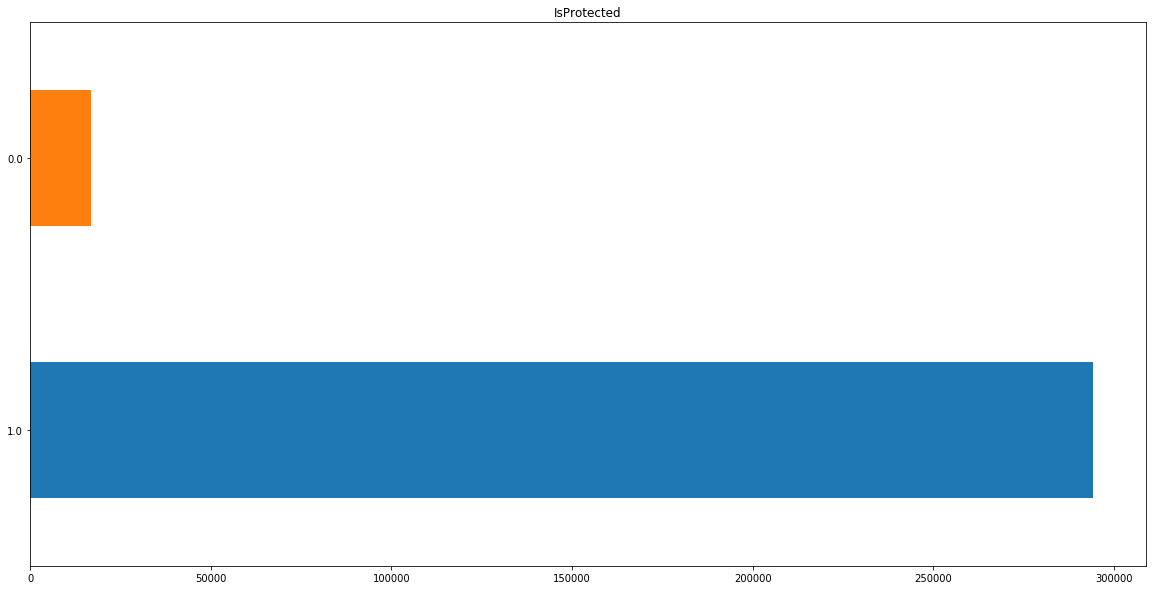

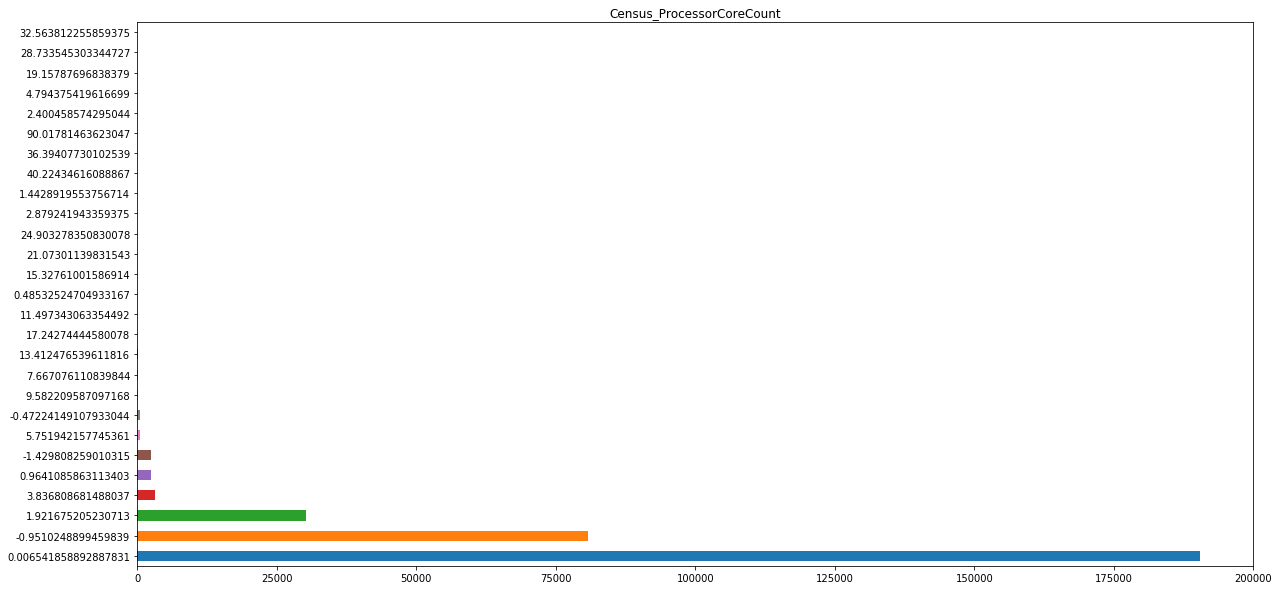

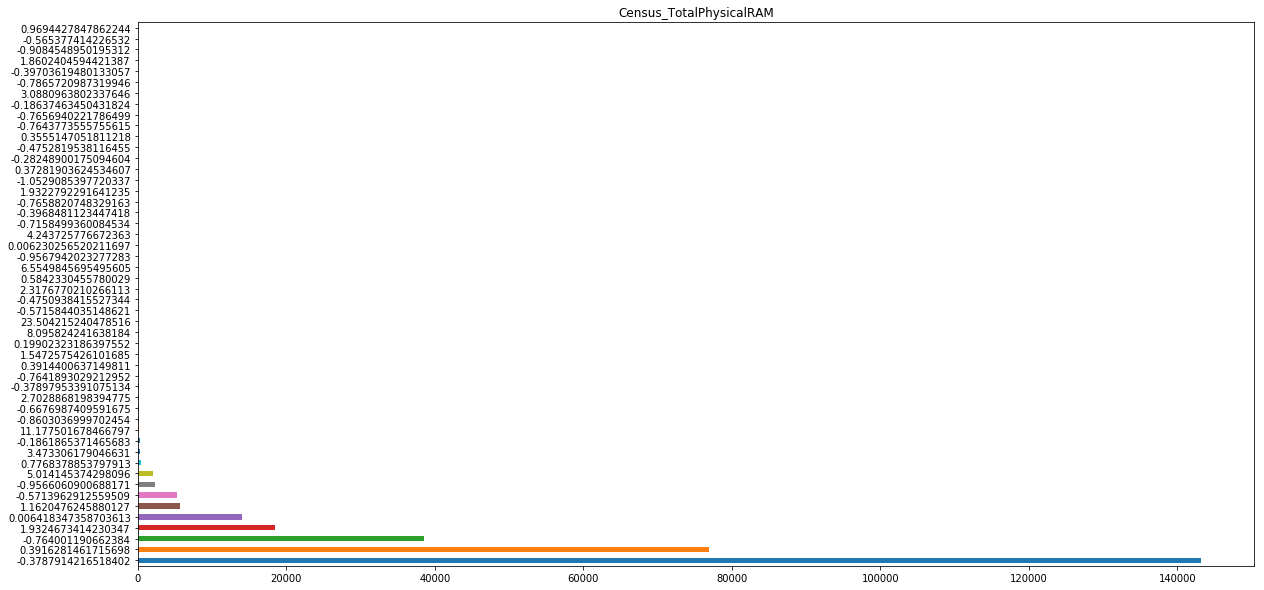

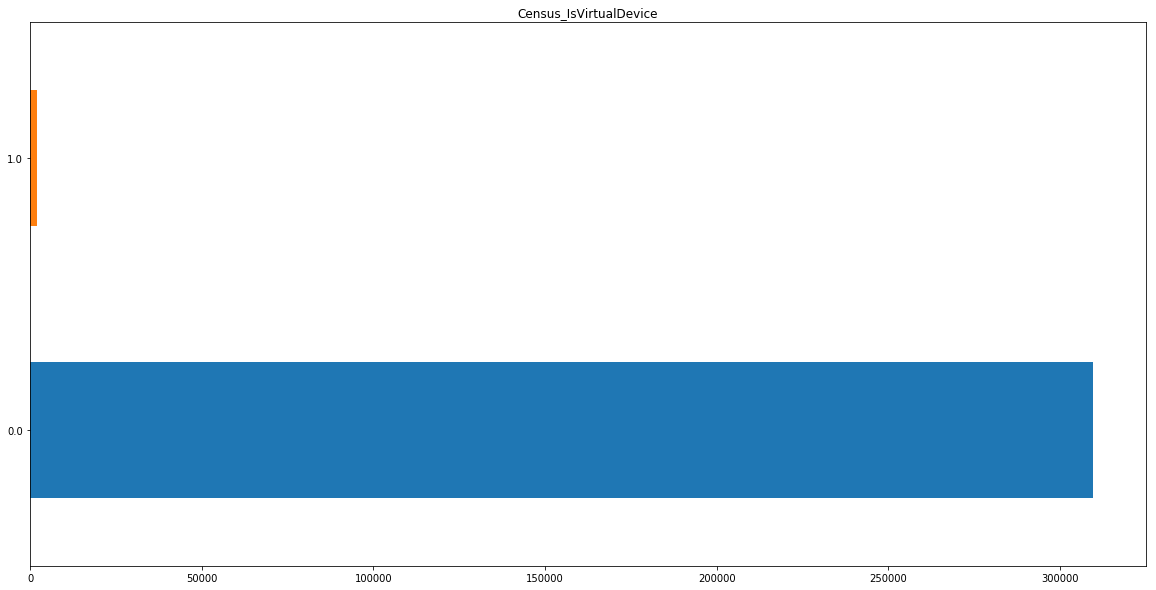

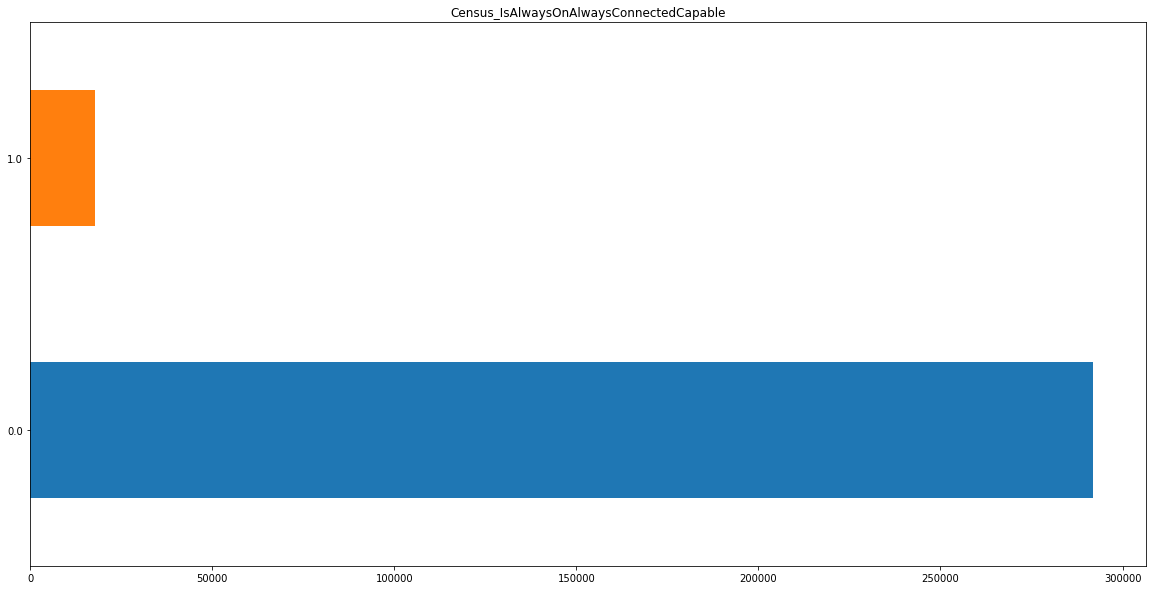

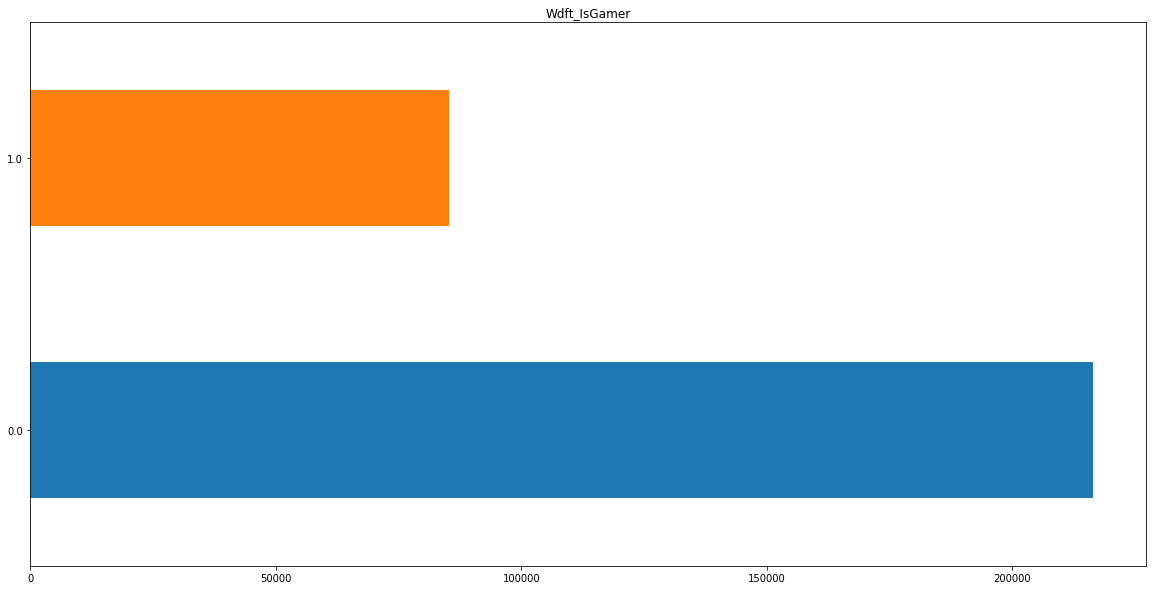

In [95]:
#Display distributions for correlated variables

import matplotlib.pyplot as plt
for i, col in enumerate(correlated_cols):
    #count = train_data[col].value_counts(sort=False).sort_values(ascending=False).nlargest(50)
    plt.figure(i)
    train_data[col].value_counts(sort=False).sort_values(ascending=False).nlargest(50).plot(kind='barh', figsize=(20,10), title=col)
 


In [103]:
X_train = train_data_corr
y_train = train_labels
X_test = dev_data_corr
y_test = dev_labels

In [108]:
classifier =  KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
classifier.fit(X_train, y_train)

pred_y = classifier.predict(X_test)

results = confusion_matrix(y_test, pred_y)
error = zero_one_loss(y_test, pred_y)
accuracy = metrics.accuracy_score(y_test, pred_y)

print(results)
print(error)
print(accuracy)

[[26948  6521]
 [25083  8359]]
0.472328914528254
0.527671085471746


In [107]:
from sklearn.svm import LinearSVC

classifier = LinearSVC()
classifier.fit(X_train, y_train)

pred_y = classifier.predict(X_test)

results = confusion_matrix(y_test, pred_y)
error = zero_one_loss(y_test, pred_y)
accuracy = metrics.accuracy_score(y_test, pred_y)

print(results)
print(error)
print(accuracy)

[[32365  1104]
 [32158  1284]]
0.4971080988178327
0.5028919011821673


/Users/kevin/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [109]:
 def run_PCA_GMM_analysis(param_threshold, X_train, X_test, y_train, y_test):
    # set up a series of conditions where the parameter sum of PCA
    # components and GMM components will be <= 50
    # Parameters will be expressed in terms of G = GMM components, 
    # P = PCA components and C = Number of classes 
    C = 2 # number of classes will always be two for this experiment
    # P and G combinations are what will change based on their relationship with
    # the covariance type
    # First line up a cartesian matrix of PCA and GMM components possibilities
    P, G = np.meshgrid(np.arange(1, param_threshold), np.arange(1, param_threshold))
    # Define possible combinations where the sum of parameters will be <= param_threshold
    # depending on the covariance type
    # The parameter count formula calculations were found on
    # https://stats.stackexchange.com/questions/280893/number-of-parameters-in-multivariate-gaussian-for-different-covariance-matrices/280896#280896
    diag_params = 2 * P * G * C <= param_threshold
    full_params = ((P * G) + (P * (P + 1) * G) / 2) * C <= param_threshold
    sphe_params = (P + 1) * G * C <= param_threshold
    tied_params = ((P * G) + (P * (P + 1)) / 2) * C <= param_threshold
    experiments = [sphe_params, diag_params, tied_params, full_params]
    CT = ['spherical', 'diag', 'tied', 'full']
    # store the winning hyperparameters
    winning_accuracy = 0.0
    winning_CT = None
    winning_PCA = None
    winning_GMM = None
    # keep track of all the trials for sorting / displaying
    trials = np.empty((0,4))
    # run through each experiment - spherical, diag, tied and full
    for i, experiment in enumerate(experiments):
    # iterate through the combinatorial product of PCA components and GMM 
    # components that sum up to less than 50 parameter combinations for the
    # experiment
        for p, g in np.column_stack((P[experiment], G[experiment])):
            pca = PCA(p)
            projected = pca.fit_transform(X_train)
            projected_test = pca.transform(X_test)

            gm_mod_pos = GaussianMixture(n_components = g, covariance_type=CT[i])
            gm_mod_pos.fit(projected[y_train==1])

            gm_mod_neg = GaussianMixture(n_components = g, covariance_type=CT[i])
            gm_mod_neg.fit(projected[y_train==0])

            prob_pos = gm_mod_pos.score_samples(projected_test)
            prob_neg = gm_mod_neg.score_samples(projected_test)

            winning_predictions = np.where(prob_pos >= prob_neg, 1, 0)
            accuracy = metrics.accuracy_score(y_test, winning_predictions)
            trials = np.append(trials, np.array([[p, g, i, accuracy]]), axis=0)
            if accuracy > winning_accuracy:
                winning_accuracy = accuracy
                winning_CT = CT[i]
                winning_PCA = p
                winning_GMM = g

    # calculate the parameter count for the winning experiment using its 
    # hyperparameters
    if winning_CT=='spherical':
        winning_params = (winning_PCA + 1) * winning_GMM * C 
    elif winning_CT=='diag':
        winning_params = (2 * winning_PCA * winning_GMM * C)
    elif winning_CT=='full':
        winning_params = ((winning_PCA * winning_GMM) + 
                          (winning_PCA * (winning_PCA + 1) * winning_GMM) / 2) * C
    elif winning_CT=='tied':
        winning_params = ((winning_PCA * winning_GMM) + 
                          (winning_PCA * (winning_PCA + 1)) / 2) * C
    print("Best accuracy is {:5.4f} with {} parameters".format(
        winning_accuracy, winning_params))
    print("PCA components = {}, GMM components = {}, covariance_type = {}".format(
        winning_PCA, winning_GMM, winning_CT))
    trials = trials[trials[:,3].argsort()[::-1], :]
    print("\n| Rank | PCA | GMM | Cov. Type | Accuracy |")
    print("+------+-----+-----+-----------+----------+")
    for i, trial in enumerate(trials):
        print("| {:4} | {:3} | {:3} | {} | {:9.4f}|".format(
            i+1, int(trial[0]), int(trial[1]),
            CT[int(trial[2])].rjust(9), trial[3]))

In [120]:
run_PCA_GMM_analysis(27, X_train, X_test, y_train, y_test)

Best accuracy is 0.5764 with 24 parameters
PCA components = 3, GMM components = 2, covariance_type = diag

| Rank | PCA | GMM | Cov. Type | Accuracy |
+------+-----+-----+-----------+----------+
|    1 |   3 |   2 |      diag |    0.5764|
|    2 |   2 |   4 |      tied |    0.5726|
|    3 |   2 |   2 |      diag |    0.5725|
|    4 |   2 |   5 |      tied |    0.5709|
|    5 |   3 |   2 |      tied |    0.5706|
|    6 |   3 |   1 |      diag |    0.5704|
|    7 |   3 |   1 |      tied |    0.5704|
|    8 |   3 |   1 |      full |    0.5704|
|    9 |   5 |   1 |      diag |    0.5699|
|   10 |   4 |   1 |      diag |    0.5699|
|   11 |   6 |   1 |      diag |    0.5697|
|   12 |   2 |   1 |      diag |    0.5693|
|   13 |   2 |   1 |      full |    0.5692|
|   14 |   2 |   1 |      tied |    0.5692|
|   15 |   2 |   2 |      tied |    0.5681|
|   16 |   2 |   3 |      diag |    0.5538|
|   17 |   2 |   3 | spherical |    0.5380|
|   18 |   3 |   3 | spherical |    0.5371|
|   19 |   2 

In [125]:
#impute for all columns and let PCA find the best dimensions
imputer = SimpleImputer(strategy = 'median')
imputer.fit(train_data)
X_train = imputer.transform(train_data)
X_test = imputer.transform(dev_data)

In [126]:
classifier =  KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
classifier.fit(X_train, y_train)

pred_y = classifier.predict(X_test)

results = confusion_matrix(y_test, pred_y)
error = zero_one_loss(y_test, pred_y)
accuracy = metrics.accuracy_score(y_test, pred_y)

print(results)
print(error)
print(accuracy)

[[27953  5516]
 [27655  5787]]
0.4957480832747979
0.5042519167252021


In [127]:
from sklearn.svm import LinearSVC

classifier = LinearSVC()
classifier.fit(X_train, y_train)

pred_y = classifier.predict(X_test)

results = confusion_matrix(y_test, pred_y)
error = zero_one_loss(y_test, pred_y)
accuracy = metrics.accuracy_score(y_test, pred_y)

print(results)
print(error)
print(accuracy)

/Users/kevin/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[[32394  1075]
 [32130  1312]]
0.4962562209502175
0.5037437790497825


In [129]:
X_train.shape

(312251, 81)

In [130]:
run_PCA_GMM_analysis(120, X_train, X_test, y_train, y_test)

Best accuracy is 0.5646 with 88 parameters
PCA components = 11, GMM components = 2, covariance_type = diag

| Rank | PCA | GMM | Cov. Type | Accuracy |
+------+-----+-----+-----------+----------+
|    1 |  11 |   2 |      diag |    0.5646|
|    2 |  15 |   2 |      diag |    0.5457|
|    3 |  14 |   2 |      diag |    0.5456|
|    4 |  13 |   2 |      diag |    0.5453|
|    5 |  11 |   1 |      diag |    0.5425|
|    6 |   4 |   3 | spherical |    0.5357|
|    7 |   5 |   3 | spherical |    0.5331|
|    8 |   8 |   2 |      tied |    0.5330|
|    9 |  12 |   2 |      diag |    0.5329|
|   10 |   1 |   3 |      full |    0.5308|
|   11 |   1 |   3 |      diag |    0.5308|
|   12 |   7 |   2 |      tied |    0.5300|
|   13 |   6 |   2 |      tied |    0.5295|
|   14 |   4 |  12 | spherical |    0.5293|
|   15 |   4 |   9 | spherical |    0.5292|
|   16 |   2 |   5 |      diag |    0.5290|
|   17 |   6 |   3 | spherical |    0.5289|
|   18 |   2 |   4 |      diag |    0.5287|
|   19 |   4

navy
0
turquoise
1


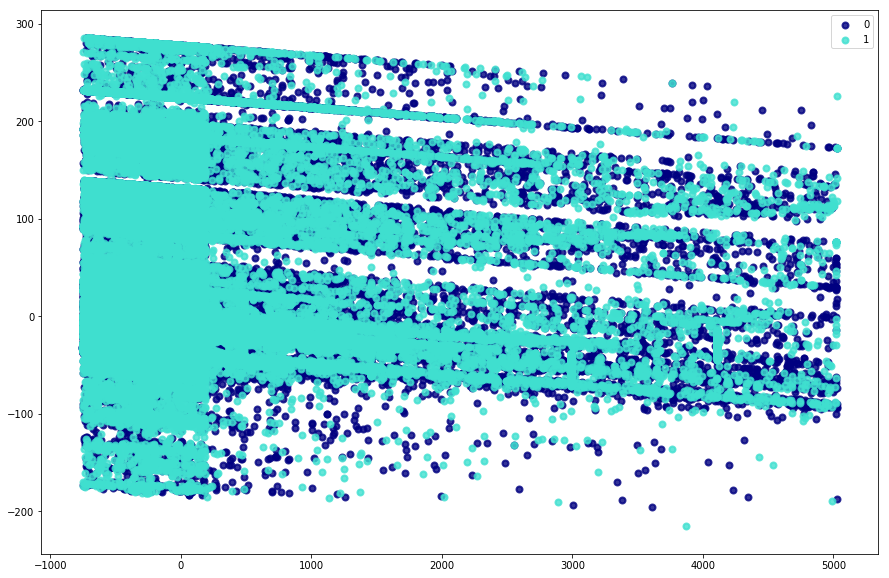

In [131]:
pca = PCA(n_components=2)
projected = pca.fit_transform(X_train)

plt.figure(figsize=(15,10))

from collections import defaultdict

category = defaultdict(list)
category[0].append('not-detected')
category[1].append('has-detections')

colors = ['navy', 'turquoise', 'darkorange', 'red', 'purple']

for color, cat in zip(colors, category.keys()):
    print(color)
    print(cat)
    plt.scatter(projected[y_train==cat, 0], projected[y_train==cat, 1],
                color=color, alpha=.8, lw=2, label=cat)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()

In [ ]:
# Feature reduction using ExtraTreesClassifier

In [132]:
fsel = ske.ExtraTreesClassifier().fit(X_train, y_train)
model = SelectFromModel(fsel, prefit=True)
X_train_data_new = model.transform(X_train)
X_test_data_new = model.transform(X_test)
nb_features = X_train_data_new.shape[1]
nb_features

/Users/kevin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


35

In [134]:
classifier =  KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
classifier.fit(X_train_data_new, y_train)

pred_y = classifier.predict(X_test_data_new)

results = confusion_matrix(y_test, pred_y)
error = zero_one_loss(y_test, pred_y)
accuracy = metrics.accuracy_score(y_test, pred_y)

print(results)
print(error)
print(accuracy)

[[28151  5318]
 [27975  5467]]
0.49757140081600937
0.5024285991839906


In [135]:
from sklearn.svm import LinearSVC

classifier = LinearSVC()
classifier.fit(X_train_data_new, y_train)

pred_y = classifier.predict(X_test_data_new)

results = confusion_matrix(y_test, pred_y)
error = zero_one_loss(y_test, pred_y)
accuracy = metrics.accuracy_score(y_test, pred_y)

print(results)
print(error)
print(accuracy)

[[33129   340]
 [32996   446]]
0.4982140455231576
0.5017859544768424


/Users/kevin/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [137]:
run_PCA_GMM_analysis(70, X_train_data_new, X_test_data_new, y_train, y_test)

Best accuracy is 0.5712 with 56 parameters
PCA components = 7, GMM components = 2, covariance_type = diag

| Rank | PCA | GMM | Cov. Type | Accuracy |
+------+-----+-----+-----------+----------+
|    1 |   7 |   2 |      diag |    0.5712|
|    2 |   7 |   1 |      tied |    0.5692|
|    3 |   7 |   1 |      full |    0.5690|
|    4 |   7 |   1 |      diag |    0.5643|
|    5 |  17 |   1 |      diag |    0.5528|
|    6 |  16 |   1 |      diag |    0.5528|
|    7 |  15 |   1 |      diag |    0.5497|
|    8 |  14 |   1 |      diag |    0.5495|
|    9 |  13 |   1 |      diag |    0.5483|
|   10 |  10 |   1 |      diag |    0.5480|
|   11 |   9 |   1 |      diag |    0.5478|
|   12 |  11 |   1 |      diag |    0.5476|
|   13 |  12 |   1 |      diag |    0.5473|
|   14 |   8 |   2 |      diag |    0.5467|
|   15 |   2 |   3 | spherical |    0.5375|
|   16 |   8 |   1 |      diag |    0.5362|
|   17 |   2 |   4 |      full |    0.5326|
|   18 |   5 |   3 | spherical |    0.5321|
|   19 |   1 

In [ ]:
# Feature reduction using Ridge regression

In [138]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='l2', solver='liblinear',
                                multi_class='ovr', C=0.18, max_iter=1000)
rfe = RFE(model, 3)
model = rfe.fit(X_train, y_train)

print("Num Features: %s" % (model.n_features_))
print("Selected Features: %s" % (model.support_))
print("Feature Ranking: %s" % (model.ranking_))

from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)


def pretty_print_coefs(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name)
                                   for coef, name in lst)

print ("Ridge model:", pretty_print_coefs(ridge.coef_, names=all_cols))


#X_train_data_new = model.transform(X_train)
#X_test_data_new = model.transform(X_test)

Num Features: 3
Selected Features: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False]
Feature Ranking: [12 62 70 78 38 32 14 63 18  5 50 10 67 60 57 77 46 15  2 23 44 35 51 69
 49  3  9  1  1 16 13 19 56 55 27 65 64 24 58 53 26 21 61 22 30 43 75 66
 33 34 47 59 54 74 28 52 39 42 36 37 40 73 76 71 11 31 48 29  6 41  7 72
 68 20 79  1 17 25  4  8 45]
Ridge model: -0.067 * ProductName + -0.002 * EngineVersion + -0.001 * AppVersion + 0.0 * AvSigVersion + 0.061 * IsBeta + 0.016 * RtpStateBitfield + 0.06 * IsSxsPassiveMode + -0.004 * DefaultBrowsersIdentifi

In [153]:
new_cols = []
#print(np.array(model.ranking_))
i=0
for c in (model.ranking_):
    if i==15: break
    print(columns[c])
    new_cols.append(columns[c])
    i=i+1

CountryIdentifier
Census_OSUILocaleIdentifier
Census_ThresholdOptIn
Census_IsAlwaysOnAlwaysConnectedCapable
Census_ProcessorManufacturerIdentifier
UacLuaenable
OrganizationIdentifier
Census_OSWUAutoUpdateOptionsName
Processor
RtpStateBitfield
Census_PowerPlatformRoleName
AVProductsEnabled
Census_IsFlightingInternal
Census_OSInstallTypeName
Census_OSBuildRevision


In [148]:
imputer = SimpleImputer(strategy = 'median')
imputer.fit(train_data[new_cols])
X_train = imputer.transform(train_data[new_cols])
X_test = imputer.transform(dev_data[new_cols])

In [149]:
classifier =  KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
classifier.fit(X_train, y_train)

pred_y = classifier.predict(X_test)

results = confusion_matrix(y_test, pred_y)
error = zero_one_loss(y_test, pred_y)
accuracy = metrics.accuracy_score(y_test, pred_y)

print(results)
print(error)
print(accuracy)

[[25222  8247]
 [24032  9410]]
0.4824169419079075
0.5175830580920925


In [150]:
from sklearn.svm import LinearSVC

classifier = LinearSVC()
classifier.fit(X_train, y_train)

pred_y = classifier.predict(X_test)

results = confusion_matrix(y_test, pred_y)
error = zero_one_loss(y_test, pred_y)
accuracy = metrics.accuracy_score(y_test, pred_y)

print(results)
print(error)
print(accuracy)

[[ 8620 24849]
 [ 6111 27331]]
0.462704189146777
0.537295810853223


/Users/kevin/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [155]:
run_PCA_GMM_analysis(33, X_train, X_test, y_train, y_test)

Best accuracy is 0.5271 with 24 parameters
PCA components = 3, GMM components = 2, covariance_type = diag

| Rank | PCA | GMM | Cov. Type | Accuracy |
+------+-----+-----+-----------+----------+
|    1 |   3 |   2 |      diag |    0.5271|
|    2 |   4 |   2 |      diag |    0.5266|
|    3 |   4 |   3 | spherical |    0.5260|
|    4 |   6 |   1 | spherical |    0.5258|
|    5 |   1 |   8 |      full |    0.5256|
|    6 |   3 |   2 |      tied |    0.5246|
|    7 |   2 |   2 |      full |    0.5246|
|    8 |   2 |   2 |      diag |    0.5245|
|    9 |   1 |  11 |      tied |    0.5244|
|   10 |   2 |   2 |      tied |    0.5243|
|   11 |   5 |   2 | spherical |    0.5241|
|   12 |   2 |   3 |      tied |    0.5235|
|   13 |   2 |   1 | spherical |    0.5235|
|   14 |   5 |   1 | spherical |    0.5232|
|   15 |   3 |   1 | spherical |    0.5231|
|   16 |   6 |   2 | spherical |    0.5228|
|   17 |   4 |   1 | spherical |    0.5227|
|   18 |   4 |   2 | spherical |    0.5225|
|   19 |   1 

navy
0
turquoise
1


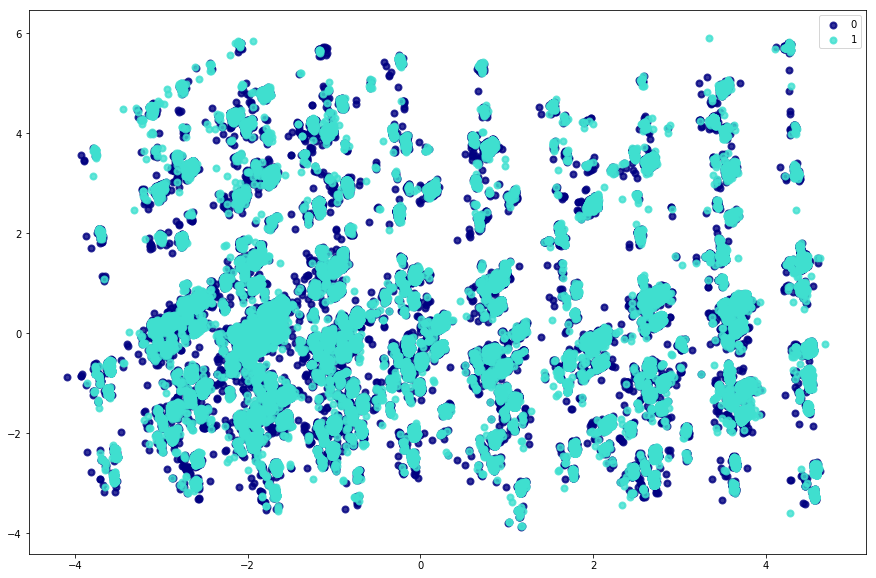

In [156]:
from sklearn.decomposition import PCA

# Use PCA to reduce dimensionality so we can visualize the dataset on a 2d plot
pca = PCA(n_components=2)
train_x_pca_cont = pca.fit_transform(X_train)

plt.figure(figsize=(15,10))

from collections import defaultdict

category = defaultdict(list)
category[0].append('not-detected')
category[1].append('has-detections')

colors = ['navy', 'turquoise', 'darkorange', 'red', 'purple']

for color, cat in zip(colors, category.keys()):
    print(color)
    print(cat)
    plt.scatter(train_x_pca_cont[y_train==cat, 0], train_x_pca_cont[y_train==cat, 1],
                color=color, alpha=.8, lw=2, label=cat)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()